In [1]:
%load_ext lab_black
%load_ext autotime
import matplotlib as mpl
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from openTSNE import TSNE
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import normalize

time: 1.48 s (started: 2023-06-27 21:07:07 -07:00)


In [2]:
from math import sqrt

import numpy as np
from numba import njit
from scipy.sparse import csr_matrix, find
from scipy.spatial.distance import cdist


def sparse_euclidean_distance_slow(csr_matrix, row1, row2):
    row1_data = find(csr_matrix[row1, :])
    row2_data = find(csr_matrix[row2, :])

    # Get the intersection of the indices
    common_indices = np.intersect1d(row1_data[1], row2_data[1])

    # Calculate the euclidean distance
    dist = np.sqrt(np.sum([row1_data[2] - row2_data[2]] ** 2 for i in common_indices))

    return dist


@njit
def euclidean_distance(v1_data, v1_indices, v2_data, v2_indices):
    distance = 0.0
    i = j = 0
    while i < len(v1_indices) and j < len(v2_indices):
        if v1_indices[i] == v2_indices[j]:
            diff = v1_data[i] - v2_data[j]
            distance += diff * diff
            i += 1
            j += 1
        elif v1_indices[i] < v2_indices[j]:
            distance += v1_data[i] * v1_data[i]
            i += 1
        else:
            distance += v2_data[j] * v2_data[j]
            j += 1
    while i < len(v1_indices):
        distance += v1_data[i] * v1_data[i]
        i += 1
    while j < len(v2_indices):
        distance += v2_data[j] * v2_data[j]
        j += 1
    return np.sqrt(distance)


def sparse_euclidean_distance(csr_matrix, row1, row2):
    row1_data = find(csr_matrix[row1, :])
    row2_data = find(csr_matrix[row2, :])

    dist = euclidean_distance(row1_data[2], row1_data[1], row2_data[2], row2_data[1])

    return dist


import numpy as np
from numba import njit, prange
from scipy.sparse import csr_matrix


def random_projection_sparse_rademacher(X, n_components, random_state=42):
    n_samples, n_features = X.shape
    projected = np.empty((n_samples, n_components))

    np.random.seed(random_state)
    return _random_projection(
        X.data,
        X.indices,
        X.indptr,
        X.shape[0],
        X.shape[1],
        n_components,
        projected,
        random_state,
    )


@njit(parallel=False)
def _random_projection(
    data, indices, indptr, n_samples, n_features, n_components, projected, random_state
):
    plus_minus = np.array([-1, 1])
    for i in prange(n_components):
        rand_signs = np.random.choice(plus_minus, size=n_features)

        for j in prange(n_samples):
            start_idx = indptr[j]
            end_idx = indptr[j + 1]
            projected[j, i] = np.sum(
                data[start_idx:end_idx] * rand_signs[indices[start_idx:end_idx]]
            )

    return projected

time: 251 ms (started: 2023-06-27 21:07:12 -07:00)


In [20]:
from drnb.eval.nbrpres import nn_acc
from drnb.io import read_pickle
from drnb.neighbors import calculate_neighbors
from drnb.neighbors.hubness import describe, k_occurrences
from drnb.preprocess import normalize

time: 7.84 ms (started: 2023-06-27 21:24:08 -07:00)


In [6]:
svd = read_pickle("ng20tfidf", suffix="svd")

time: 44.8 s (started: 2023-06-27 21:07:59 -07:00)


In [7]:
rprojg = read_pickle("ng20tfidf", suffix="rprojg")

time: 48.4 s (started: 2023-06-27 21:08:44 -07:00)


In [8]:
svd.shape

(18846, 4000)

time: 6.88 ms (started: 2023-06-27 21:10:04 -07:00)


In [9]:
rprojg.shape

(18846, 4000)

time: 4.36 ms (started: 2023-06-27 21:10:11 -07:00)


In [29]:
tfidf_dense = read_pickle("ng20tfidf", suffix="dense")

FileNotFoundError: Missing pickle file /home/james/rdev/datasets/ng20tfidf-dense for compression ['bz2', 'gzip', '']

time: 96.4 ms (started: 2023-06-27 21:35:14 -07:00)


In [26]:
tfidf_dense_nbrs16 = read_pickle("ng20tfidf", suffix="nbrs16")

time: 200 ms (started: 2023-06-27 21:33:33 -07:00)


In [12]:
newsgroups = fetch_20newsgroups(subset="all")

time: 245 ms (started: 2023-06-27 21:14:14 -07:00)


In [40]:
def knn_accuracy(X, y=newsgroups.target, k=10, balanced=False):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    if balanced:
        y_pred = neigh.predict(X_test)
        return balanced_accuracy_score(y_test, y_pred)
    return neigh.score(X_test, y_test)

def knn_recall(ref_nn, Y, k=10):
    y_nbrs = calculate_neighbors(
        Y,
        n_neighbors=k,
        metric="euclidean",
        method="exact",
        return_distance=False,
        include_self=False,
    )
    return nn_acc(y_nbrs.idx[:, :k], ref_nn.idx[:, 1 : (k + 1)])


def knn_recall_faiss(x, y, n_neighbors=10):
    x_nbrs = calculate_neighbors(
        x,
        n_neighbors=n_neighbors,
        metric="euclidean",
        method="exact",
        return_distance=False,
        include_self=False,
    )
    y_nbrs = calculate_neighbors(
        y,
        n_neighbors=n_neighbors,
        metric="euclidean",
        method="exact",
        return_distance=False,
        include_self=False,
    )
    return nn_acc(x_nbrs.idx[:, :n_neighbors], y_nbrs.idx[:, :n_neighbors])


def tsne_scatter(X, target, alpha=1.0, size=1, palette="tab10", k=10):
    coords = TSNE().fit(X)
    seascatter(coords, target, alpha=alpha, size=size, palette=palette)
    return knn_recall_faiss(X, coords, n_neighbors=k), knn_accuracy(coords, k=k)


def seascatter(coords, target, alpha=1.0, size=1, palette="tab10"):
    data = pd.DataFrame({"X": coords[:, 0], "Y": coords[:, 1], "Color": target})

    sns.scatterplot(
        x="X",
        y="Y",
        hue="Color",
        palette=palette,
        size=size,
        data=data,
        legend=False,
        alpha=alpha,
    )

time: 28.4 ms (started: 2023-06-27 21:53:05 -07:00)


In [61]:
knn_recall(tfidf_dense_nbrs150, TSNE().fit(svd[:, :500]), k=10)

[22:46:42] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=413500;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=504920;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:46:43] INFO     Automatically determined negative gradient method `fft`                              ]8;id=760885;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=813086;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:46:52] INFO     Automatically determined negative gradient method `fft`                              ]8;id=508007;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=428783;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

0.3619176483073331

time: 1min 53s (started: 2023-06-27 22:46:00 -07:00)


In [62]:
knn_recall(tfidf_dense_nbrs150, TSNE().fit(rprojg[:, :500]), k=10)

[22:48:50] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=201821;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=915588;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=604229;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=1288;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:48:59] INFO     Automatically determined negative gradient method `fft`                              ]8;id=782152;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=819288;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

0.3476387562347448

time: 2min 2s (started: 2023-06-27 22:47:54 -07:00)


In [36]:
[knn_recall(tfidf_dense_nbrs16, svd[:, :nc], k=10) for nc in [100, 200, 300, 400, 500]]

[0.2773373660193144,
 0.3350843680356575,
 0.36453358802929003,
 0.38217658919664643,
 0.39281014538894193]

time: 2.92 s (started: 2023-06-27 21:37:17 -07:00)


In [48]:
[knn_recall(tfidf_dense_nbrs16, svd[:, :nc], k=15) for nc in [100, 200, 300, 400, 500]]

[0.27025717216739187,
 0.3240970674590541,
 0.3505783720683434,
 0.36514202837029963,
 0.3737415543528247]

time: 3.03 s (started: 2023-06-27 22:10:46 -07:00)


In [57]:
[
    knn_recall(tfidf_dense_nbrs150, svd[:, :nc], k=10)
    for nc in [100, 200, 300, 400, 500]
], [
    knn_recall(tfidf_dense_nbrs150, rprojg[:, :nc], k=10)
    for nc in [100, 200, 300, 400, 500]
]

([0.2773373660193144,
  0.3350843680356575,
  0.36453358802929003,
  0.38217658919664643,
  0.39281014538894193],
 [0.23262761328663908,
  0.35071102621245887,
  0.4248381619441791,
  0.4783667621776504,
  0.5180038204393506])

time: 7.21 s (started: 2023-06-27 22:30:57 -07:00)


In [56]:
[
    knn_recall(tfidf_dense_nbrs150, svd[:, :nc], k=50)
    for nc in [100, 200, 300, 400, 500]
], [
    knn_recall(tfidf_dense_nbrs150, rprojg[:, :nc], k=50)
    for nc in [100, 200, 300, 400, 500]
]

([0.25962113976440626,
  0.2961678870847926,
  0.305438819908734,
  0.3052127772471612,
  0.3001093070147512],
 [0.10028016555237187,
  0.16461318051575932,
  0.21327072057731083,
  0.2546354664119707,
  0.2879985142735859])

time: 7.22 s (started: 2023-06-27 22:30:34 -07:00)


In [37]:
[
    knn_recall(tfidf_dense_nbrs16, rprojg[:, :nc], k=10)
    for nc in [100, 200, 300, 400, 500]
]

[0.23262761328663908,
 0.35071102621245887,
 0.4248381619441791,
 0.4783667621776504,
 0.5180038204393506]

time: 2.93 s (started: 2023-06-27 21:37:29 -07:00)


In [47]:
[
    knn_recall(tfidf_dense_nbrs16, rprojg[:, :nc], k=15)
    for nc in [100, 200, 300, 400, 500]
]

[0.1875906469984789,
 0.29279068944780506,
 0.3628073154338675,
 0.4163288407796526,
 0.45674059924298704]

time: 3.21 s (started: 2023-06-27 22:10:29 -07:00)


In [59]:
knn_accuracy(svd[:, :500], k=50), knn_accuracy(rprojg[:, :500], k=50),

(0.6949602122015915, 0.7161803713527851)

time: 1 s (started: 2023-06-27 22:35:12 -07:00)


In [44]:
knn_accuracy(svd[:, :300]), knn_accuracy(rprojg[:, :300]),

(0.7687002652519894, 0.7076923076923077)

time: 716 ms (started: 2023-06-27 22:03:55 -07:00)


[21:53:57] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=729759;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=28913;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[21:53:58] INFO     Automatically determined negative gradient method `fft`                              ]8;id=870138;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=112755;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[21:54:07] INFO     Automatically determined negative gradient method `fft`                              ]8;id=278639;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=417699;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

(0.42108670274859383, 0.709814323607427)

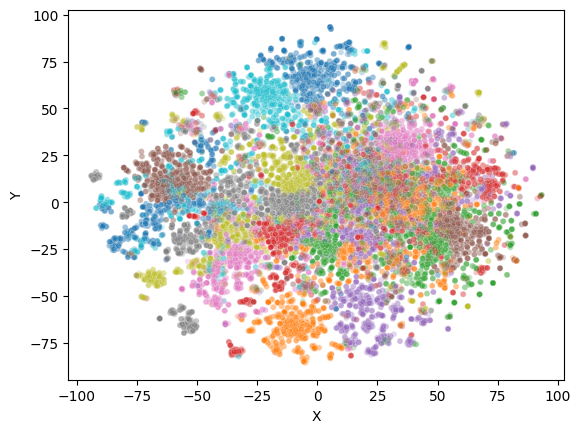

time: 1min 53s (started: 2023-06-27 21:53:14 -07:00)


In [41]:
tsne_scatter(svd[:, :500], newsgroups.target, alpha=0.25, size=0.75)

[21:56:16] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=274599;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=614275;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=861249;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=164646;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[21:56:25] INFO     Automatically determined negative gradient method `fft`                              ]8;id=449408;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=837396;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

(0.3288761540910538, 0.6058355437665782)

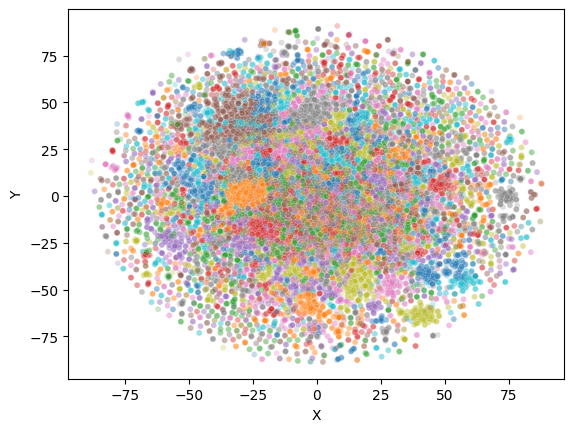

time: 2min (started: 2023-06-27 21:55:20 -07:00)


In [42]:
tsne_scatter(rprojg[:, :500], newsgroups.target, alpha=0.25, size=0.75)

[23:00:57] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=346281;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=364297;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[23:00:58] INFO     Automatically determined negative gradient method `fft`                              ]8;id=623002;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=781591;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[23:01:06] INFO     Automatically determined negative gradient method `fft`                              ]8;id=826695;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=889580;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

(0.5028706356786586, 0.7538461538461538)

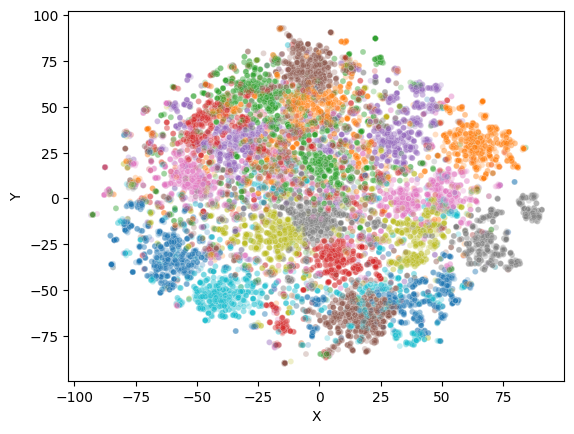

time: 1min 54s (started: 2023-06-27 23:00:15 -07:00)


In [65]:
tsne_scatter(normalize(svd[:, :500], "l2"), newsgroups.target, alpha=0.25, size=0.75)

[23:03:06] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=170006;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=765104;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[23:03:07] INFO     Automatically determined negative gradient method `fft`                              ]8;id=377041;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=969760;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[23:03:15] INFO     Automatically determined negative gradient method `fft`                              ]8;id=167515;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=226881;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

(0.3557518836888464, 0.6514588859416446)

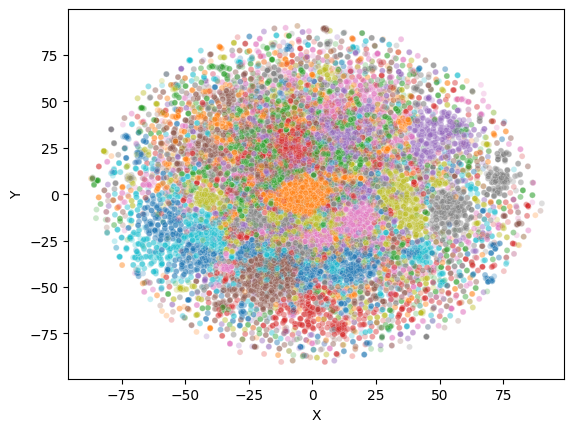

time: 2min (started: 2023-06-27 23:02:10 -07:00)


In [66]:
tsne_scatter(normalize(rprojg[:, :500], "l2"), newsgroups.target, alpha=0.25, size=0.75)

[22:04:42] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=159997;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=676688;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:04:43] INFO     Automatically determined negative gradient method `fft`                              ]8;id=27803;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=741855;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:04:52] INFO     Automatically determined negative gradient method `fft`                              ]8;id=651891;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=283201;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

(0.4269287912554388, 0.7050397877984085)

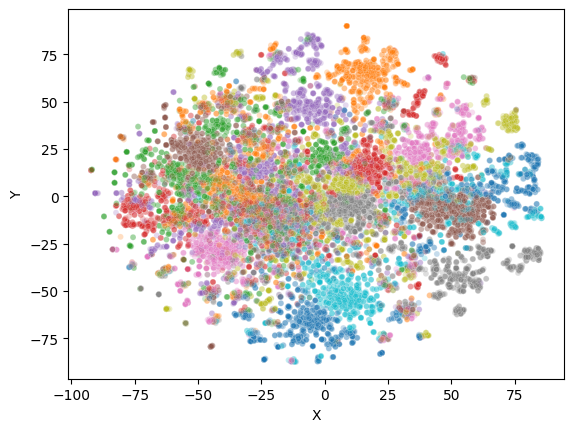

time: 1min 34s (started: 2023-06-27 22:04:16 -07:00)


In [45]:
tsne_scatter(svd[:, :300], newsgroups.target, alpha=0.25, size=0.75)

[22:06:28] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=103381;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=344497;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:06:29] INFO     Automatically determined negative gradient method `fft`                              ]8;id=37550;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=357991;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:06:37] INFO     Automatically determined negative gradient method `fft`                              ]8;id=910697;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=582342;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

(0.294672609572323, 0.5713527851458886)

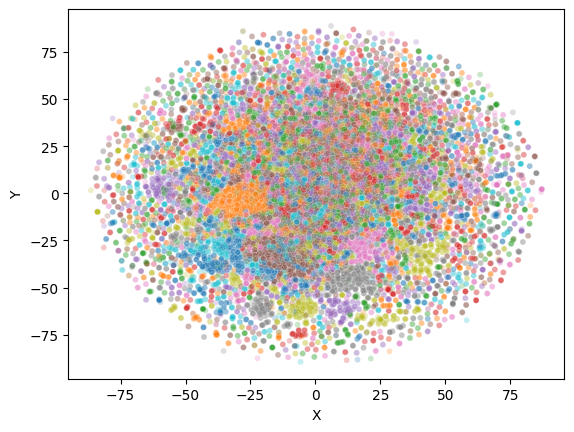

time: 1min 41s (started: 2023-06-27 22:05:51 -07:00)


In [46]:
tsne_scatter(rprojg[:, :300], newsgroups.target, alpha=0.25, size=0.75)

In [12]:
all_components = [10, 50, 100, 200, 300, 400, 500, 1000, 2000, 3000, 3500, 4000]

time: 1.58 ms (started: 2023-06-15 21:36:25 -07:00)


In [17]:
def describe_all(data, all_components, n_neighbors=10, include_self=False):
    df = pd.DataFrame()
    for nc in all_components:
        nn = calculate_neighbors(
            data[:, :nc],
            n_neighbors=n_neighbors,
            metric="euclidean",
            method="exact",
            return_distance=False,
            include_self=include_self,
        )
        desc = describe(k_occurrences(nn.idx))
        df = pd.concat([df, desc], axis=1)
    df.columns = [str(nc) for nc in all_components]
    return df

def nno(x, y, n_components=None, n_neighbors=10):
    x_nbrs = calculate_neighbors(
        x[:, :n_components],
        n_neighbors=n_neighbors,
        metric="euclidean",
        method="exact",
        return_distance=False,
        include_self=False,
    )
    y_nbrs = calculate_neighbors(
        y[:, :n_components],
        n_neighbors=n_neighbors,
        metric="euclidean",
        method="exact",
        return_distance=False,
        include_self=False,
    )
    return nn_acc(x_nbrs.idx[:, :n_neighbors], y_nbrs.idx[:, :n_neighbors])

time: 22.9 ms (started: 2023-06-27 21:21:32 -07:00)


In [107]:
nno(normalize(svd), normalize(rprojg), 4000, 10)

0.7782712511938874

time: 2.69 s (started: 2023-06-15 23:19:33 -07:00)


In [111]:
nno(svd, rprojg, 4000, 10)

0.4532739042767696

time: 2.08 s (started: 2023-06-15 23:26:32 -07:00)


In [108]:
nno(normalize(svd), normalize(rprojg), 300, 10)

0.29200360819272

time: 1.47 s (started: 2023-06-15 23:25:41 -07:00)


In [110]:
nno(svd, rprojg, 300, 10)

0.2780696168948318

time: 821 ms (started: 2023-06-15 23:25:59 -07:00)


In [ ]:
describe(
    k_occurrences(
        calculate_neighbors(
            svd[:, :10],
            n_neighbors=10,
            metric="euclidean",
            method="exact",
            return_distance=False,
            include_self=False,
        ).idx
    )
)

In [26]:
svd_df = describe_all(svd, all_components)

time: 6.05 s (started: 2023-06-15 21:40:11 -07:00)


In [27]:
svd_df

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.761419      8.974366     11.515274     17.325409     28.807385   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000      4.000000      4.000000      3.000000      3.000000   
50%        9.000000      8.000000      7.000000      7.000000      6.000000   
75%       14.000000     13.000000     12.000000     12.000000     11.000000   
max       37.000000    126.000000    251.000000    684.000000   1831.000000   
skew       0.677681      2.414938      5.166446     15.314441     35.672786   
#0       194.000000    486.000000    593.000000    726.000000    767.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       45.633332     63.459063    130.554682    189.835856    223.607533   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      3.000000      2.000000      2.000000   
50%        6.000000      6.000000      5.000000      4.000000      4.000000   
75%       11.000000     10.000000      9.000000      7.000000      7.000000   
max     3600.000000   5106.000000  10614.000000  14595.000000  15961.000000   
skew      50.573055     54.107523     56.494352     56.889329     54.563907   
#0       822.000000    879.000000   1000.000000   1220.000000   1229.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std      221.204317    220.840430  
min        0.000000      0.000000  
25%        2.000000      2.000000  
50%        4.000000      4.000000  
75%        7.000000      7.000000  
max    15901.000000  14869.000000  
skew      56.402415     56.501254  
#0      1086.000000    851.000000

time: 14.7 ms (started: 2023-06-15 21:40:18 -07:00)


In [28]:
rprojs = read_pickle("ng20tfidf", suffix="rprojs")
rprojs_df = describe_all(rprojs, all_components)

time: 16 s (started: 2023-06-15 21:41:15 -07:00)


In [29]:
rprojs_df

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       63.656944     21.097990     61.039236    184.001968    236.619367   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      1.000000      1.000000      0.000000      0.000000   
50%        9.000000      3.000000      2.000000      2.000000      2.000000   
75%       13.000000      8.000000      5.000000      3.000000      3.000000   
max     2774.000000    228.000000   3491.000000  16327.000000  18271.000000   
skew      42.797228      4.315036     25.330705     54.895656     53.613028   
#0      3027.000000   3449.000000   4656.000000   5017.000000   4941.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std      232.635877    257.566877    193.405407    115.432503    116.846154   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      1.000000      1.000000      2.000000      2.000000   
50%        2.000000      2.000000      3.000000      5.000000      5.000000   
75%        4.000000      4.000000      6.000000      9.000000     10.000000   
max    18469.000000  17584.000000  16382.000000  10034.000000  11121.000000   
skew      50.829106     51.278300     57.573335     57.183198     69.400137   
#0      4540.000000   4276.000000   2859.000000   1743.000000   1357.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std       68.808593     58.418648  
min        0.000000      0.000000  
25%        3.000000      3.000000  
50%        6.000000      6.000000  
75%       11.000000     11.000000  
max     6789.000000   6763.000000  
skew      70.823989     87.502319  
#0      1081.000000    974.000000

time: 14.9 ms (started: 2023-06-15 21:41:43 -07:00)


In [34]:
rprojg = read_pickle("ng20tfidf", suffix="rprojg")
rprojgl2_df = describe_all(renormalize(rprojg, "l2"), all_components)
rprojgl2_df

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.691522     17.393246     19.457890     19.751121     18.347219   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        5.000000      2.000000      2.000000      2.000000      3.000000   
50%       10.000000      5.000000      5.000000      5.000000      6.000000   
75%       14.000000     11.000000     10.000000     10.000000     11.000000   
max       31.000000    400.000000    487.000000    513.000000    915.000000   
skew       0.338079      6.102025      8.293349      9.634159     15.650212   
#0       334.000000   1755.000000   1673.000000   1429.000000   1115.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       15.466497     15.697370     10.962712      8.377907      7.986284   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      4.000000      5.000000      5.000000   
50%        6.000000      6.000000      7.000000      8.000000      8.000000   
75%       12.000000     12.000000     13.000000     13.000000     13.000000   
max      352.000000    621.000000    323.000000    131.000000    123.000000   
skew       7.449293     11.327381      6.640883      3.017647      2.988622   
#0       986.000000    867.000000    541.000000    380.000000    294.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std        7.776972      7.768589  
min        0.000000      0.000000  
25%        5.000000      5.000000  
50%        8.000000      8.000000  
75%       13.000000     13.000000  
max      120.000000    122.000000  
skew       2.797698      2.938886  
#0       308.000000    281.000000

time: 42 s (started: 2023-06-15 21:47:23 -07:00)


In [45]:
describe_all(renormalize(rprojg, "l2"), all_components, n_neighbors=50)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      50.000000     50.000000     50.000000     50.000000     50.000000   
std       30.336928     84.404449     95.784021    104.855071    101.121491   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       25.000000      9.000000      8.000000      8.000000      9.000000   
50%       46.000000     22.000000     20.000000     19.000000     21.000000   
75%       71.000000     56.000000     51.000000     48.000000     50.000000   
max      146.000000   1831.000000   1991.000000   2234.000000   3521.000000   
skew       0.498032      5.411826      6.473930      7.473049      9.207850   
#0        14.000000    299.000000    344.000000    312.000000    235.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      50.000000     50.000000     50.000000     50.000000     50.000000   
std       96.283404     99.431507     81.527160     59.428434     51.697881   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       10.000000     10.000000     14.000000     19.000000     22.000000   
50%       22.000000     23.000000     28.000000     34.000000     37.000000   
75%       51.000000     51.000000     55.000000     60.000000     61.000000   
max     1926.000000   3150.000000   2150.000000   1131.000000    971.000000   
skew       6.706464      9.095621      7.755073      5.491572      5.499317   
#0       184.000000    148.000000     72.000000     16.000000     10.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      50.000000     50.000000  
std       48.483035     46.768244  
min        0.000000      0.000000  
25%       23.000000     24.000000  
50%       39.000000     39.000000  
75%       62.000000     62.000000  
max     1011.000000    886.000000  
skew       5.195788      5.160715  
#0         9.000000      4.000000

time: 5.41 s (started: 2023-06-15 22:07:07 -07:00)


In [46]:
describe_all(rprojg, all_components, n_neighbors=50)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      50.000000     50.000000     50.000000     50.000000     50.000000   
std       30.339522     84.695469     98.358624    109.365238    103.898711   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       25.000000      8.000000      7.000000      7.000000      8.000000   
50%       46.000000     22.000000     19.000000     18.000000     20.000000   
75%       71.000000     56.000000     51.000000     47.000000     48.000000   
max      145.000000   1873.000000   2289.000000   2865.000000   3698.000000   
skew       0.497917      5.402728      6.946288      8.096883      8.274780   
#0        19.000000    293.000000    350.000000    337.000000    256.000000   

                400           500         1000          2000          3000  \
count  18846.000000  18846.000000  18846.00000  18846.000000  18846.000000   
mean      50.000000     50.000000     50.00000     50.000000     50.000000   
std      101.948979    108.086417     96.66656     74.539625     69.772778   
min        0.000000      0.000000      0.00000      0.000000      0.000000   
25%        9.000000      9.000000     12.00000     16.000000     18.000000   
50%       21.000000     21.000000     25.00000     31.000000     33.000000   
75%       49.000000     49.000000     52.00000     57.000000     59.000000   
max     2383.000000   3935.000000   3471.00000   1970.000000   3461.000000   
skew       7.109522     10.168022     10.39764      7.558968     11.698486   
#0       208.000000    192.000000     89.00000     37.000000     27.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      50.000000     50.000000  
std       64.960525     64.022956  
min        0.000000      0.000000  
25%       19.000000     20.000000  
50%       34.000000     35.000000  
75%       60.000000     60.000000  
max     2348.000000   2670.000000  
skew       9.320920     10.601539  
#0        24.000000     19.000000

time: 5.12 s (started: 2023-06-15 22:07:23 -07:00)


In [35]:
svdl2_df = describe_all(renormalize(svd, "l2"), all_components)
svdl2_df

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.774915      8.888669     11.345137     16.396299     25.131615   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000      4.000000      4.000000      3.000000      3.000000   
50%        9.000000      8.000000      7.000000      7.000000      7.000000   
75%       14.000000     13.000000     13.000000     12.000000     11.000000   
max       38.000000     94.000000    282.000000    707.000000   1791.000000   
skew       0.650113      2.317309      5.471173     14.663530     34.129956   
#0       206.000000    592.000000    756.000000    939.000000    991.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       38.045636     53.438109     83.290331    116.997405     91.081664   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      3.000000      4.000000      5.000000   
50%        7.000000      6.000000      6.000000      6.000000      7.000000   
75%       11.000000     11.000000     10.000000     10.000000     11.000000   
max     3275.000000   4381.000000   8064.000000   8638.000000   8477.000000   
skew      53.004446     56.798180     64.245471     57.110725     77.054058   
#0      1043.000000   1036.000000   1018.000000    717.000000    194.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std       14.082530      6.802205  
min        0.000000      0.000000  
25%        6.000000      6.000000  
50%        9.000000      9.000000  
75%       12.000000     13.000000  
max     1462.000000    142.000000  
skew      66.620195      3.398561  
#0        40.000000     69.000000

time: 5.32 s (started: 2023-06-15 21:49:31 -07:00)


In [36]:
svdl1_df = describe_all(renormalize(svd, "l1"), all_components)
svdl1_df

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.731694      9.001583     11.515297     16.335043     24.191184   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000      4.000000      4.000000      3.000000      3.000000   
50%        9.000000      8.000000      7.000000      7.000000      6.000000   
75%       14.000000     13.000000     13.000000     12.000000     11.000000   
max       36.000000     95.000000    260.000000    687.000000   1701.000000   
skew       0.646222      2.392233      5.170353     13.347246     31.933790   
#0       208.000000    572.000000    734.000000    929.000000   1012.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       35.557036     48.864830     77.134116    103.903477     88.816118   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      3.000000      4.000000      5.000000   
50%        6.000000      6.000000      6.000000      6.000000      8.000000   
75%       11.000000     10.000000     10.000000      9.000000     11.000000   
max     2940.000000   3928.000000   7248.000000   8139.000000   8485.000000   
skew      48.616848     53.955057     64.102855     54.206946     76.085612   
#0      1041.000000   1087.000000   1042.000000    713.000000    216.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std        8.625617      4.575037  
min        0.000000      0.000000  
25%        6.000000      7.000000  
50%        9.000000      9.000000  
75%       12.000000     13.000000  
max      545.000000     38.000000  
skew      27.642437      0.877513  
#0        60.000000     24.000000

time: 5.42 s (started: 2023-06-15 21:50:28 -07:00)


In [41]:
describe_all(svd, all_components)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.761419      8.974366     11.515274     17.325409     28.807385   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000      4.000000      4.000000      3.000000      3.000000   
50%        9.000000      8.000000      7.000000      7.000000      6.000000   
75%       14.000000     13.000000     12.000000     12.000000     11.000000   
max       37.000000    126.000000    251.000000    684.000000   1831.000000   
skew       0.677681      2.414938      5.166446     15.314441     35.672786   
#0       194.000000    486.000000    593.000000    726.000000    767.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       45.633332     63.459063    130.554682    189.835856    223.607533   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      3.000000      2.000000      2.000000   
50%        6.000000      6.000000      5.000000      4.000000      4.000000   
75%       11.000000     10.000000      9.000000      7.000000      7.000000   
max     3600.000000   5106.000000  10614.000000  14595.000000  15961.000000   
skew      50.573055     54.107523     56.494352     56.889329     54.563907   
#0       822.000000    879.000000   1000.000000   1220.000000   1229.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std      221.204317    220.840430  
min        0.000000      0.000000  
25%        2.000000      2.000000  
50%        4.000000      4.000000  
75%        7.000000      7.000000  
max    15901.000000  14869.000000  
skew      56.402415     56.501254  
#0      1086.000000    851.000000

time: 13.3 s (started: 2023-06-15 21:53:42 -07:00)


In [30]:
rprojg = read_pickle("ng20tfidf", suffix="rprojg")
rprojg_df = describe_all(rprojg, all_components)
rprojg_df

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.696293     17.461282     20.187800     20.851843     18.440444   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000      2.000000      2.000000      2.000000      2.250000   
50%       10.000000      5.000000      5.000000      5.000000      6.000000   
75%       14.000000     11.000000     10.000000     10.000000     11.000000   
max       31.000000    424.000000    576.000000    701.000000    917.000000   
skew       0.346273      6.168133      9.166736     11.137560     13.169807   
#0       330.000000   1775.000000   1726.000000   1483.000000   1176.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       16.531485     17.213170     13.142140      9.578830      9.039620   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      4.000000      4.000000      5.000000   
50%        6.000000      6.000000      7.000000      8.000000      8.000000   
75%       11.000000     12.000000     12.000000     13.000000     13.000000   
max      480.000000    778.000000    635.000000    215.000000    305.000000   
skew       8.357980     13.898477     12.958332      4.754626      5.190753   
#0      1077.000000    939.000000    620.000000    439.000000    381.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std        8.685832      8.703555  
min        0.000000      0.000000  
25%        5.000000      5.000000  
50%        8.000000      8.000000  
75%       13.000000     13.000000  
max      184.000000    198.000000  
skew       4.066257      4.418201  
#0       364.000000    355.000000

time: 46.7 s (started: 2023-06-15 21:42:46 -07:00)


In [42]:
describe_all(renormalize(svd, "l1"), all_components)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.731694      9.001583     11.515297     16.335043     24.191184   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000      4.000000      4.000000      3.000000      3.000000   
50%        9.000000      8.000000      7.000000      7.000000      6.000000   
75%       14.000000     13.000000     13.000000     12.000000     11.000000   
max       36.000000     95.000000    260.000000    687.000000   1701.000000   
skew       0.646222      2.392233      5.170353     13.347246     31.933790   
#0       208.000000    572.000000    734.000000    929.000000   1012.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       35.557036     48.864830     77.134116    103.903477     88.816118   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      3.000000      4.000000      5.000000   
50%        6.000000      6.000000      6.000000      6.000000      8.000000   
75%       11.000000     10.000000     10.000000      9.000000     11.000000   
max     2940.000000   3928.000000   7248.000000   8139.000000   8485.000000   
skew      48.616848     53.955057     64.102855     54.206946     76.085612   
#0      1041.000000   1087.000000   1042.000000    713.000000    216.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std        8.625617      4.575037  
min        0.000000      0.000000  
25%        6.000000      7.000000  
50%        9.000000      9.000000  
75%       12.000000     13.000000  
max      545.000000     38.000000  
skew      27.642437      0.877513  
#0        60.000000     24.000000

time: 5.36 s (started: 2023-06-15 21:55:14 -07:00)


In [90]:
describe_all(rprojg, all_components)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.696293     17.461282     20.187800     20.851843     18.440444   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000      2.000000      2.000000      2.000000      2.250000   
50%       10.000000      5.000000      5.000000      5.000000      6.000000   
75%       14.000000     11.000000     10.000000     10.000000     11.000000   
max       31.000000    424.000000    576.000000    701.000000    917.000000   
skew       0.346273      6.168133      9.166736     11.137560     13.169807   
#0       330.000000   1775.000000   1726.000000   1483.000000   1176.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       16.531485     17.213170     13.142140      9.578830      9.039620   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      4.000000      4.000000      5.000000   
50%        6.000000      6.000000      7.000000      8.000000      8.000000   
75%       11.000000     12.000000     12.000000     13.000000     13.000000   
max      480.000000    778.000000    635.000000    215.000000    305.000000   
skew       8.357980     13.898477     12.958332      4.754626      5.190753   
#0      1077.000000    939.000000    620.000000    439.000000    381.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std        8.685832      8.703555  
min        0.000000      0.000000  
25%        5.000000      5.000000  
50%        8.000000      8.000000  
75%       13.000000     13.000000  
max      184.000000    198.000000  
skew       4.066257      4.418201  
#0       364.000000    355.000000

time: 4.95 s (started: 2023-06-15 23:09:18 -07:00)


In [89]:
describe_all(renormalize(rprojg, "l2"), all_components)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.691522     17.393246     19.457890     19.751121     18.347219   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        5.000000      2.000000      2.000000      2.000000      3.000000   
50%       10.000000      5.000000      5.000000      5.000000      6.000000   
75%       14.000000     11.000000     10.000000     10.000000     11.000000   
max       31.000000    400.000000    487.000000    513.000000    915.000000   
skew       0.338079      6.102025      8.293349      9.634159     15.650212   
#0       334.000000   1755.000000   1673.000000   1429.000000   1115.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       15.466497     15.697370     10.962712      8.377907      7.986284   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      4.000000      5.000000      5.000000   
50%        6.000000      6.000000      7.000000      8.000000      8.000000   
75%       12.000000     12.000000     13.000000     13.000000     13.000000   
max      352.000000    621.000000    323.000000    131.000000    123.000000   
skew       7.449293     11.327381      6.640883      3.017647      2.988622   
#0       986.000000    867.000000    541.000000    380.000000    294.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std        7.776972      7.768589  
min        0.000000      0.000000  
25%        5.000000      5.000000  
50%        8.000000      8.000000  
75%       13.000000     13.000000  
max      120.000000    122.000000  
skew       2.797698      2.938886  
#0       308.000000    281.000000

time: 5.3 s (started: 2023-06-15 23:09:12 -07:00)


In [58]:
describe_all(renormalize(svd, "l2"), all_components)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.774915      8.888669     11.345137     16.396299     25.131615   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000      4.000000      4.000000      3.000000      3.000000   
50%        9.000000      8.000000      7.000000      7.000000      7.000000   
75%       14.000000     13.000000     13.000000     12.000000     11.000000   
max       38.000000     94.000000    282.000000    707.000000   1791.000000   
skew       0.650113      2.317309      5.471173     14.663530     34.129956   
#0       206.000000    592.000000    756.000000    939.000000    991.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       38.045636     53.438109     83.290331    116.997405     91.081664   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      3.000000      4.000000      5.000000   
50%        7.000000      6.000000      6.000000      6.000000      7.000000   
75%       11.000000     11.000000     10.000000     10.000000     11.000000   
max     3275.000000   4381.000000   8064.000000   8638.000000   8477.000000   
skew      53.004446     56.798180     64.245471     57.110725     77.054058   
#0      1043.000000   1036.000000   1018.000000    717.000000    194.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std       14.082530      6.802205  
min        0.000000      0.000000  
25%        6.000000      6.000000  
50%        9.000000      9.000000  
75%       12.000000     13.000000  
max     1462.000000    142.000000  
skew      66.620195      3.398561  
#0        40.000000     69.000000

time: 5.34 s (started: 2023-06-15 22:48:40 -07:00)


In [59]:
describe_all(renormalize(rprojg, "l2"), all_components)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.691522     17.393246     19.457890     19.751121     18.347219   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        5.000000      2.000000      2.000000      2.000000      3.000000   
50%       10.000000      5.000000      5.000000      5.000000      6.000000   
75%       14.000000     11.000000     10.000000     10.000000     11.000000   
max       31.000000    400.000000    487.000000    513.000000    915.000000   
skew       0.338079      6.102025      8.293349      9.634159     15.650212   
#0       334.000000   1755.000000   1673.000000   1429.000000   1115.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       15.466497     15.697370     10.962712      8.377907      7.986284   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      4.000000      5.000000      5.000000   
50%        6.000000      6.000000      7.000000      8.000000      8.000000   
75%       12.000000     12.000000     13.000000     13.000000     13.000000   
max      352.000000    621.000000    323.000000    131.000000    123.000000   
skew       7.449293     11.327381      6.640883      3.017647      2.988622   
#0       986.000000    867.000000    541.000000    380.000000    294.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std        7.776972      7.768589  
min        0.000000      0.000000  
25%        5.000000      5.000000  
50%        8.000000      8.000000  
75%       13.000000     13.000000  
max      120.000000    122.000000  
skew       2.797698      2.938886  
#0       308.000000    281.000000

time: 5.19 s (started: 2023-06-15 22:48:48 -07:00)


In [31]:
describe(k_occurrences(read_pickle("ng20tfidf", suffix="nbrs16").idx[:, :10]))

count    18846.000000
mean        10.000000
std          7.136898
min          1.000000
25%          5.000000
50%          9.000000
75%         13.000000
max        115.000000
skew         3.037131
#0           0.000000
dtype: float64

time: 197 ms (started: 2023-06-15 21:45:54 -07:00)


In [56]:
14869.000000 / 18846.000000

0.7889737875411228

time: 3.51 ms (started: 2023-06-15 22:40:11 -07:00)


<Axes: ylabel='Count'>

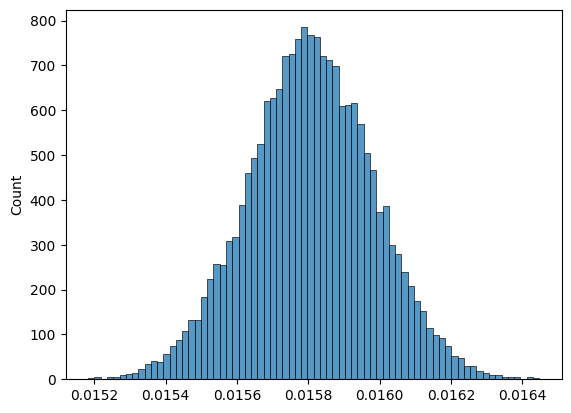

time: 516 ms (started: 2023-06-15 23:06:57 -07:00)


In [88]:
sns.histplot(np.std(rprojg[:, :4000], axis=1))

<Axes: ylabel='Count'>

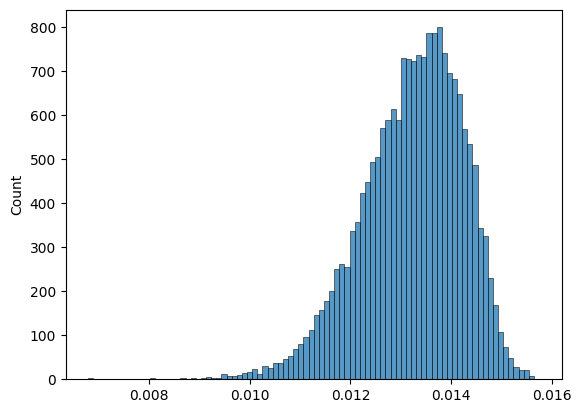

time: 552 ms (started: 2023-06-15 23:06:52 -07:00)


In [87]:
sns.histplot(np.std(svd[:, :4000], axis=1))

In [ ]:
nn_acc(y_nbrs.idx[:, :k], ref_nn.idx[:, 1 : (k + 1)])

In [48]:
describe_all(svd, all_components, include_self=True)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.240352      8.058028     10.282629     15.429068     25.604461   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%        6.000000      5.000000      4.000000      4.000000      4.000000   
50%        9.000000      8.000000      7.000000      7.000000      7.000000   
75%       13.000000     13.000000     12.000000     11.000000     11.000000   
max       34.000000    114.000000    219.000000    627.000000   1647.000000   
skew       0.674752      2.369823      5.021276     15.453434     36.576416   
#0         0.000000      0.000000      0.000000      0.000000      0.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       40.953724     56.953411    117.490223    171.321271    201.369013   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%        4.000000      4.000000      3.000000      3.000000      3.000000   
50%        6.000000      6.000000      6.000000      5.000000      5.000000   
75%       11.000000     10.000000      9.000000      8.000000      7.000000   
max     3309.000000   4718.000000  10054.000000  13950.000000  15384.000000   
skew      52.643959     56.277613     59.537635     60.519782     58.375883   
#0         0.000000      0.000000      0.000000      0.000000      0.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std      200.653710    200.212693  
min        1.000000      1.000000  
25%        3.000000      3.000000  
50%        5.000000      5.000000  
75%        7.000000      8.000000  
max    15340.000000  14159.000000  
skew      60.504566     59.323924  
#0         0.000000      0.000000

time: 5.1 s (started: 2023-06-15 22:10:05 -07:00)


In [44]:
describe_all(svd, all_components, n_neighbors=50)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      50.000000     50.000000     50.000000     50.000000     50.000000   
std       26.860385     45.956938     63.247726    105.249803    167.086396   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       29.000000     20.000000     17.000000     15.000000     13.250000   
50%       46.000000     37.000000     33.000000     29.000000     25.000000   
75%       67.000000     65.000000     60.000000     53.000000     46.000000   
max      155.000000    650.000000   1299.000000   3281.000000   6929.000000   
skew       0.652226      2.699170      6.145496     13.210743     21.045689   
#0         5.000000     30.000000     21.000000     34.000000     52.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      50.000000     50.000000     50.000000     50.000000     50.000000   
std      238.171470    306.758987    540.327195    705.579479    734.563712   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       12.000000     11.000000      7.000000      5.000000      4.000000   
50%       22.000000     20.000000     13.000000      9.000000      8.000000   
75%       42.000000     37.000000     24.000000     16.000000     15.000000   
max    10651.000000  13276.000000  17996.000000  18710.000000  18772.000000   
skew      25.487091     27.094094     24.838331     22.931269     22.474750   
#0        68.000000     89.000000    191.000000    295.000000    235.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      50.000000     50.000000  
std      720.708492    685.734653  
min        0.000000      0.000000  
25%        5.000000      5.000000  
50%        9.000000     10.000000  
75%       16.000000     18.000000  
max    18775.000000  18769.000000  
skew      22.911291     23.674659  
#0       151.000000     74.000000

time: 5.27 s (started: 2023-06-15 22:05:00 -07:00)


In [50]:
describe_all(svd, all_components)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.761419      8.974366     11.515274     17.325409     28.807385   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000      4.000000      4.000000      3.000000      3.000000   
50%        9.000000      8.000000      7.000000      7.000000      6.000000   
75%       14.000000     13.000000     12.000000     12.000000     11.000000   
max       37.000000    126.000000    251.000000    684.000000   1831.000000   
skew       0.677681      2.414938      5.166446     15.314441     35.672786   
#0       194.000000    486.000000    593.000000    726.000000    767.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       45.633332     63.459063    130.554682    189.835856    223.607533   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      3.000000      2.000000      2.000000   
50%        6.000000      6.000000      5.000000      4.000000      4.000000   
75%       11.000000     10.000000      9.000000      7.000000      7.000000   
max     3600.000000   5106.000000  10614.000000  14595.000000  15961.000000   
skew      50.573055     54.107523     56.494352     56.889329     54.563907   
#0       822.000000    879.000000   1000.000000   1220.000000   1229.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std      221.204317    220.840430  
min        0.000000      0.000000  
25%        2.000000      2.000000  
50%        4.000000      4.000000  
75%        7.000000      7.000000  
max    15901.000000  14869.000000  
skew      56.402415     56.501254  
#0      1086.000000    851.000000

time: 5.12 s (started: 2023-06-15 22:12:34 -07:00)


In [51]:
describe_all(rprojg, all_components)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.696293     17.461282     20.187800     20.851843     18.440444   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000      2.000000      2.000000      2.000000      2.250000   
50%       10.000000      5.000000      5.000000      5.000000      6.000000   
75%       14.000000     11.000000     10.000000     10.000000     11.000000   
max       31.000000    424.000000    576.000000    701.000000    917.000000   
skew       0.346273      6.168133      9.166736     11.137560     13.169807   
#0       330.000000   1775.000000   1726.000000   1483.000000   1176.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       16.531485     17.213170     13.142140      9.578830      9.039620   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      4.000000      4.000000      5.000000   
50%        6.000000      6.000000      7.000000      8.000000      8.000000   
75%       11.000000     12.000000     12.000000     13.000000     13.000000   
max      480.000000    778.000000    635.000000    215.000000    305.000000   
skew       8.357980     13.898477     12.958332      4.754626      5.190753   
#0      1077.000000    939.000000    620.000000    439.000000    381.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std        8.685832      8.703555  
min        0.000000      0.000000  
25%        5.000000      5.000000  
50%        8.000000      8.000000  
75%       13.000000     13.000000  
max      184.000000    198.000000  
skew       4.066257      4.418201  
#0       364.000000    355.000000

time: 4.99 s (started: 2023-06-15 22:12:43 -07:00)


In [52]:
newsgroups = fetch_20newsgroups(subset="all")

tfidf = TfidfVectorizer(sublinear_tf=True).fit_transform(newsgroups.data)

time: 3.98 s (started: 2023-06-15 22:15:16 -07:00)


In [53]:
rprojr = random_projection_sparse_rademacher(tfidf, 4000, random_state=42)

time: 1min 4s (started: 2023-06-15 22:15:34 -07:00)


In [54]:
describe_all(rprojr, all_components)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.676781     16.693472     20.098854     20.048995     17.729434   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        5.000000      2.000000      2.000000      2.000000      3.000000   
50%       10.000000      5.000000      5.000000      5.000000      6.000000   
75%       14.000000     11.000000     10.000000     11.000000     11.000000   
max       32.000000    380.000000    606.000000    685.000000    539.000000   
skew       0.324151      5.823491      8.502624     10.927451      8.828600   
#0       302.000000   1640.000000   1708.000000   1422.000000   1209.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       17.807338     16.558087     11.601525      9.652684      9.018268   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      4.000000      4.000000      5.000000   
50%        6.000000      6.000000      7.000000      8.000000      8.000000   
75%       11.000000     12.000000     13.000000     13.000000     13.000000   
max      590.000000    479.000000    266.000000    239.000000    232.000000   
skew      10.685994     10.300908      5.967433      5.578314      5.270809   
#0      1049.000000    942.000000    633.000000    466.000000    388.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std        8.774109      8.859961  
min        0.000000      0.000000  
25%        5.000000      5.000000  
50%        8.000000      8.000000  
75%       13.000000     13.000000  
max      223.000000    238.000000  
skew       4.777722      5.416683  
#0       384.000000    364.000000

time: 7.68 s (started: 2023-06-15 22:16:39 -07:00)


In [55]:
describe_all(
    random_projection_sparse_rademacher(tfidf, 4000, random_state=42), all_components
)

10            50           100           200           300  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std        5.669382     16.782472     20.542435     20.799448     19.495279   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000      2.000000      2.000000      2.000000      3.000000   
50%       10.000000      5.000000      5.000000      5.000000      6.000000   
75%       14.000000     11.000000     10.000000     11.000000     11.000000   
max       31.000000    294.000000    576.000000    847.000000    885.000000   
skew       0.334204      5.657760      8.688223     11.616092     13.302270   
#0       323.000000   1713.000000   1692.000000   1418.000000   1223.000000   

                400           500          1000          2000          3000  \
count  18846.000000  18846.000000  18846.000000  18846.000000  18846.000000   
mean      10.000000     10.000000     10.000000     10.000000     10.000000   
std       18.939333     16.352563     12.218885     10.382088      8.976447   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      3.000000      4.000000      4.000000      5.000000   
50%        6.000000      6.000000      7.000000      8.000000      8.000000   
75%       11.000000     12.000000     12.000000     13.000000     13.000000   
max      847.000000    655.000000    343.000000    444.000000    238.000000   
skew      14.393262     11.299481      7.539569      9.323613      4.479685   
#0      1054.000000    988.000000    666.000000    481.000000    436.000000   

               3500          4000  
count  18846.000000  18846.000000  
mean      10.000000     10.000000  
std        8.720269      8.479294  
min        0.000000      0.000000  
25%        5.000000      5.000000  
50%        8.000000      8.000000  
75%       13.000000     13.000000  
max      180.000000    159.000000  
skew       3.907837      3.435614  
#0       407.000000    387.000000

time: 1min 9s (started: 2023-06-15 22:18:36 -07:00)


In [ ]:
describe_all(
    random_projection_sparse_rademacher(tfidf, 4000, random_state=42), all_components
)

In [39]:
X = csr_matrix(np.random.rand(5000, 100))
# projected_X = random_projection_sparse_rademacher(X, 10, random_state=42)

time: 16.3 ms (started: 2023-06-14 07:56:57 -07:00)


In [46]:
projected_X = random_projection_sparse_rademacher(X, 10, random_state=42)

time: 18.6 ms (started: 2023-06-14 07:57:39 -07:00)


In [45]:
X[:, :10].toarray(), projected_X

(array([[0.37454012, 0.95071431, 0.73199394, ..., 0.86617615, 0.60111501,
         0.70807258],
        [0.03142919, 0.63641041, 0.31435598, ..., 0.75555114, 0.22879817,
         0.07697991],
        [0.64203165, 0.08413996, 0.16162871, ..., 0.66350177, 0.00506158,
         0.16080805],
        ...,
        [0.57339227, 0.55404726, 0.80563856, ..., 0.11668915, 0.28318765,
         0.43867726],
        [0.94017031, 0.08172919, 0.16874534, ..., 0.59457033, 0.25868589,
         0.07462142],
        [0.47394693, 0.87186157, 0.0344097 , ..., 0.34484373, 0.17011604,
         0.86389727]]),
 array([[ 2.12693303, -1.76022279, -2.6211997 , ...,  4.58232415,
         -4.36244888,  2.44772938],
        [ 0.81855031, -2.29919349, -4.99581816, ..., -1.78546116,
         -0.19655086, -4.47317772],
        [ 4.49282121, -0.77116762, -6.7453817 , ...,  5.09808453,
          3.62041023, -0.87961677],
        ...,
        [ 1.96377663, -2.88532273,  0.99802924, ...,  6.04476847,
         -4.12901881, -1

time: 6.03 ms (started: 2023-06-14 07:57:37 -07:00)


In [3]:
all_components = [10, 50, 100, 200, 300, 400, 500, 1000, 2000, 3000, 3500, 4000]

time: 1.29 ms (started: 2023-06-15 21:20:58 -07:00)


In [49]:
newsgroups = fetch_20newsgroups(subset="all")

tfidf = TfidfVectorizer(sublinear_tf=True).fit_transform(newsgroups.data)

time: 4.35 s (started: 2023-06-27 22:13:26 -07:00)


In [50]:
tfidf_dense = tfidf.todense()

time: 6.89 s (started: 2023-06-27 22:13:35 -07:00)


In [51]:
tfidf.shape, tfidf_dense.shape

((18846, 173762), (18846, 173762))

time: 3.85 ms (started: 2023-06-27 22:13:50 -07:00)


In [52]:
tfidf_dense_nbrs150 = calculate_neighbors(
    tfidf_dense,
    n_neighbors=150,
    metric="euclidean",
    method="exact",
    return_distance=True,
    include_self=True,
)

time: 14min 7s (started: 2023-06-27 22:14:22 -07:00)


In [53]:
from drnb.io import read_pickle, write_pickle

time: 1.11 ms (started: 2023-06-27 22:28:39 -07:00)


In [54]:
write_pickle(tfidf_dense_nbrs150, "ng20tfidf", suffix="nbrs150", compression="gzip")

PosixPath('/home/james/rdev/datasets/ng20tfidf-nbrs150.pkl.gz')

time: 17.7 s (started: 2023-06-27 22:28:43 -07:00)


In [39]:
tfidf_dense_nbrs16 = calculate_neighbors(
    tfidf_dense,
    n_neighbors=16,
    metric="euclidean",
    method="exact",
    return_distance=True,
    include_self=True,
)

[07:53:24] INFO     Loading faiss with AVX2 support.                ]8;id=959540;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=96598;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\
           INFO     Could not load library with AVX2 support due    ]8;id=515996;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=33431;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    to:                                                         
                    ModuleNotFoundError("No module named                        
                    'faiss.swigfaiss_avx2'")                                    
           INFO     Loading faiss.                                  ]8;id=563728;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=891287

In [38]:
tfidf_dense[0, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

time: 4.17 ms (started: 2023-06-13 07:52:35 -07:00)


In [6]:
tfidf_dense_nbrs16 = read_pickle("ng20tfidf", suffix="nbrs16")

time: 4.1 s (started: 2023-06-14 07:32:37 -07:00)


In [7]:
tfidf_dense_nbrs16

NearestNeighbors(idx=array([[    0, 11485,  2729, ...,  6760, 11946,  2867],
       [    1,  6468, 11766, ...,  7609,  4277,  7423],
       [    2, 12577, 15736, ...,  7182,   115, 11165],
       ...,
       [18843,  4351,  4617, ..., 14965,  8161, 18800],
       [18844, 11518, 10404, ..., 18075,  8542, 12779],
       [18845, 17662,  1654, ...,  1327, 12852,  9542]]), info=NbrInfo(name='', n_nbrs=16, metric='euclidean', exact=True, method='faiss', has_distances=True, idx_path=None, dist_path=None), dist=array([[3.4526698e-04, 1.1584038e+00, 1.1925033e+00, ..., 1.2721022e+00,
        1.2730944e+00, 1.2731344e+00],
       [4.8828125e-04, 1.2297548e+00, 1.2388475e+00, ..., 1.2787511e+00,
        1.2807388e+00, 1.2816111e+00],
       [0.0000000e+00, 8.3238792e-01, 9.9490726e-01, ..., 1.2555586e+00,
        1.2606161e+00, 1.2676331e+00],
       ...,
       [3.4526698e-04, 1.2155225e+00, 1.2171375e+00, ..., 1.2948937e+00,
        1.2985282e+00, 1.3000988e+00],
       [4.8828125e-04, 9.302231

time: 6.88 ms (started: 2023-06-13 20:36:49 -07:00)


In [42]:
#write_pickle(tfidf_dense_nbrs16, "ng20tfidf", suffix="nbrs16", compression="gzip")

PosixPath('/home/james/rdev/datasets/ng20tfidf-nbrs16.pkl.gz')

time: 2.03 s (started: 2023-06-13 08:19:21 -07:00)


In [ ]:
svd = TruncatedSVD(
    n_components=np.max(all_components), random_state=42, algorithm="arpack"
).fit_transform(tfidf)

In [7]:
def knn_accuracy(X, y=newsgroups.target, k=10, balanced=False):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    if balanced:
        y_pred = neigh.predict(X_test)
        return balanced_accuracy_score(y_test, y_pred)
    return neigh.score(X_test, y_test)

time: 3.29 ms (started: 2023-06-14 07:32:42 -07:00)


In [91]:
from drnb.eval.nbrpres import nn_acc
from drnb.neighbors import calculate_neighbors


def knn_recall(ref_nn, Y, k=10):
    y_nbrs = calculate_neighbors(
        Y,
        n_neighbors=k,
        metric="euclidean",
        method="exact",
        return_distance=False,
        include_self=False,
    )
    return nn_acc(y_nbrs.idx[:, :k], ref_nn.idx[:, 1 : (k + 1)])

time: 11.2 ms (started: 2023-06-15 23:12:23 -07:00)


In [9]:
tfidf.shape

(18846, 173762)

time: 7.08 ms (started: 2023-06-14 07:32:45 -07:00)


In [5]:
Zs = []

for nc in all_components:
    print(".", end="")

    Z1 = TSNE().fit(svd[:, :nc])
    Z2 = TSNE().fit(normalize(svd[:, :nc], axis=1))

    Zs.append((Z1, Z2))

............time: 1h 17min 11s (started: 2023-06-03 10:51:28 -07:00)


In [6]:
print(f"TF-IDF: {knn_accuracy(tfidf):.2f}\n")

print("SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))")

for i, nc in enumerate(all_components):
    print(
        f"    {nc:4}     {knn_accuracy(svd[:,:nc]):.2f}"
        f"        {knn_accuracy(normalize(svd[:,:nc], axis=1)):.2f}"
        f"          {knn_accuracy(Zs[i][0]):.2f}"
        f"              {knn_accuracy(Zs[i][1]):.2f}"
    )

TF-IDF: 0.83

SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))
      10     0.55        0.57          0.52              0.52
      50     0.74        0.75          0.68              0.70
     100     0.76        0.78          0.70              0.73
     200     0.77        0.78          0.70              0.73
     300     0.77        0.78          0.70              0.74
     400     0.75        0.79          0.72              0.75
     500     0.75        0.79          0.71              0.75
    1000     0.72        0.80          0.72              0.76
    2000     0.70        0.82          0.67              0.76
    3000     0.70        0.82          0.65              0.76
    3500     0.70        0.82          0.68              0.76
    4000     0.72        0.83          0.68              0.76
time: 1min 47s (started: 2023-06-03 12:08:39 -07:00)


In [4]:
from sklearn.random_projection import SparseRandomProjection

time: 1.15 ms (started: 2023-06-12 07:57:54 -07:00)


In [9]:
from sklearn.random_projection import SparseRandomProjection

rproj = SparseRandomProjection(
    n_components=np.max(all_components), random_state=42, dense_output=True
).fit_transform(tfidf)

time: 5.74 s (started: 2023-06-12 08:03:49 -07:00)


In [10]:
Zps = []

for nc in all_components:
    print(f"{nc}")
    Z1 = TSNE().fit(rproj[:, :nc])
    Z2 = TSNE().fit(normalize(rproj[:, :nc], axis=1))

    Zps.append((Z1, Z2))

10
50
100
200
300
400
500
1000
2000
3000
3500
4000
time: 1h 18min 36s (started: 2023-06-12 08:03:57 -07:00)


In [12]:
print(f"TF-IDF: {knn_accuracy(tfidf):.2f}\n")

print("RProj dim      RProj     L2(RProj)    t-SNE(RProj)    t-SNE(L2(RProj))")

for i, nc in enumerate(all_components):
    print(
        f"    {nc:4}     {knn_accuracy(rproj[:,:nc]):.2f}"
        f"        {knn_accuracy(normalize(rproj[:,:nc], axis=1)):.2f}"
        f"          {knn_accuracy(Zps[i][0]):.2f}"
        f"              {knn_accuracy(Zps[i][1]):.2f}"
    )

TF-IDF: 0.83

RProj dim      RProj     L2(RProj)    t-SNE(RProj)    t-SNE(L2(RProj))
      10     0.10        0.10          0.10              0.10
      50     0.25        0.31          0.23              0.25
     100     0.30        0.47          0.29              0.36
     200     0.37        0.63          0.40              0.52
     300     0.42        0.69          0.45              0.57
     400     0.45        0.73          0.51              0.63
     500     0.48        0.76          0.52              0.65
    1000     0.66        0.80          0.60              0.69
    2000     0.74        0.81          0.66              0.73
    3000     0.76        0.82          0.68              0.74
    3500     0.79        0.82          0.68              0.74
    4000     0.80        0.82          0.71              0.74
time: 1min 48s (started: 2023-06-12 09:37:56 -07:00)


In [14]:
np.where(np.array(all_components) == 500)[0][0]

6

In [13]:
# all in one
Zps = []
print(f"TF-IDF: {knn_accuracy(tfidf):.2f}\n")

print(
    "RProj dim      RProj     L2(RProj)    t-SNE(RProj)    t-SNE(L2(RProj))    L2(t-SNE(RProj))    L2(t-SNE(L2(RProj)))"
)
for i, nc in enumerate(all_components):
    rproj = SparseRandomProjection(
        n_components=nc, random_state=42, dense_output=True
    ).fit_transform(tfidf)
    Z1 = TSNE().fit(rproj)
    Z2 = TSNE().fit(normalize(rproj, axis=1))

    Zps.append((Z1, Z2))
    print(
        f"    {nc:4}     {knn_accuracy(rproj):.2f}"
        f"        {knn_accuracy(normalize(rproj, axis=1)):.2f}"
        f"          {knn_accuracy(Z1):.2f}"
        f"              {knn_accuracy(Z2):.2f}"
        f"                  {knn_accuracy(normalize(Z1, axis=1)):.2f}"
        f"                      {knn_accuracy(normalize(Z2, axis=1)):.2f}"
    )

TF-IDF: 0.83

RProj dim      RProj     L2(RProj)    t-SNE(RProj)    t-SNE(L2(RProj))    L2(t-SNE(RProj))    L2(t-SNE(L2(RProj)))
      10     0.10        0.10          0.11              0.10                  0.06                      0.07
      50     0.24        0.30          0.23              0.24                  0.13                      0.13
     100     0.31        0.45          0.29              0.36                  0.18                      0.17
     200     0.36        0.61          0.38              0.49                  0.20                      0.24
     300     0.44        0.69          0.45              0.59                  0.24                      0.25
     400     0.49        0.72          0.49              0.61                  0.27                      0.30
     500     0.48        0.77          0.52              0.68                  0.26                      0.37
    1000     0.67        0.79          0.62              0.70                  0.33                  

In [ ]:
# gauss all in one
from sklearn.random_projection import GaussianRandomProjection

Zpgs = []
print("RProjG dim      RProjG     L2(RProjG)    t-SNE(RProjG)    t-SNE(L2(RProjG))")
for i, nc in enumerate(all_components):
    rprojg = GaussianRandomProjection(n_components=nc, random_state=42).fit_transform(tfidf)
    Z1 = TSNE().fit(rprojg)
    Z2 = TSNE().fit(normalize(rprojg, axis=1))

    Zpgs.append((Z1, Z2))
    print(
        f"    {nc:4}     {knn_accuracy(rprojg):.2f}"
        f"        {knn_accuracy(normalize(rprojg, axis=1)):.2f}"
        f"          {knn_accuracy(Z1):.2f}"
        f"              {knn_accuracy(Z2):.2f}"
    )

RProjG dim      RProjG     L2(RProjG)    t-SNE(RProjG)    t-SNE(L2(RProjG))
      10     0.09        0.10          0.08              0.09
      50     0.35        0.38          0.26              0.29
     100     0.51        0.56          0.41              0.45
     200     0.65        0.69          0.52              0.57
     300     0.71        0.73          0.57              0.60
     400     0.73        0.75          0.60              0.64
     500     0.76        0.77          0.61              0.67
    1000     0.80        0.80          0.67              0.72
    2000     0.81        0.81          0.71              0.73
    3000     0.82        0.82          0.73              0.74


In [6]:
from sklearn.random_projection import GaussianRandomProjection

print("RProjG dim      RProjG     L2(RProjG)    t-SNE(RProjG)    t-SNE(L2(RProjG))")
for i, nc in enumerate([4000]):
    rprojg = GaussianRandomProjection(n_components=nc, random_state=42).fit_transform(
        tfidf
    )
    Z1 = TSNE().fit(rprojg)
    Z2 = TSNE().fit(normalize(rprojg, axis=1))

    print(
        f"    {nc:4}     {knn_accuracy(rprojg):.2f}"
        f"        {knn_accuracy(normalize(rprojg, axis=1)):.2f}"
        f"          {knn_accuracy(Z1):.2f}"
        f"              {knn_accuracy(Z2):.2f}"
    )

RProjG dim      RProjG     L2(RProjG)    t-SNE(RProjG)    t-SNE(L2(RProjG))
    4000     0.82        0.82          0.72              0.76
time: 18min 12s (started: 2023-06-12 19:49:23 -07:00)


In [45]:
from sklearn.random_projection import SparseRandomProjection

rproj = SparseRandomProjection(
    n_components=np.max(all_components), random_state=42, dense_output=True
).fit_transform(tfidf)

time: 5.77 s (started: 2023-06-13 08:22:23 -07:00)


In [49]:
print("RProj dim      RProj     L2(RProj)    t-SNE(RProj)    t-SNE(L2(RProj))")

for i, nc in enumerate(all_components):
    Z1 = TSNE().fit(rproj[:, :nc])
    Z2 = TSNE().fit(normalize(rproj[:, :nc], axis=1))
    print(
        f"    {nc:4}     {knn_recall(tfidf_dense_nbrs16, rproj[:, :nc]):.2f}"
        f"        {knn_recall(tfidf_dense_nbrs16, normalize(rproj[:, :nc], axis=1)):.2f}"
        f"          {knn_recall(tfidf_dense_nbrs16, Z1):.2f}"
        f"              {knn_recall(tfidf_dense_nbrs16, Z2):.2f}"
    )

RProj dim      RProj     L2(RProj)    t-SNE(RProj)    t-SNE(L2(RProj))
[08:38:44] INFO     Precomputed initialization provided. Ignoring   ]8;id=146096;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=469519;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\
                    initalization-related parameters.                           
           INFO     Automatically determined negative gradient method ]8;id=815772;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=863614;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\
                    `fft`                                                       
[08:38:52] INFO     Automatically determined negative gradient method ]8;id=595832;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=322611;

In [11]:
svd = TruncatedSVD(
    n_components=np.max(all_components), random_state=42, algorithm="arpack"
).fit_transform(tfidf)

time: 1h 29min 19s (started: 2023-06-13 20:37:15 -07:00)


In [12]:
print("SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))")

for i, nc in enumerate(all_components):
    svdc = svd[:, :nc]
    Z1 = TSNE().fit(svdc)
    Z2 = TSNE().fit(normalize(svdc, axis=1))
    print(
        f"    {nc:4}     {knn_recall(tfidf_dense_nbrs16, svdc):.2f}"
        f"        {knn_recall(tfidf_dense_nbrs16, normalize(svdc, axis=1)):.2f}"
        f"          {knn_recall(tfidf_dense_nbrs16, Z1):.2f}"
        f"              {knn_recall(tfidf_dense_nbrs16, Z2):.2f}"
    )

SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))


[22:06:47] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=71820;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=228720;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=261491;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=789314;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:06:56] INFO     Automatically determined negative gradient method `fft`                              ]8;id=485898;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=733697;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:08:04] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=84653;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=5105;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=897121;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=625108;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:08:12] INFO     Automatically determined negative gradient method `fft`                              ]8;id=897479;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=43323;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:09:11] INFO     Loading faiss with AVX2 support.                                                   ]8;id=592175;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=314711;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=439167;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=560185;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=288422;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=220285;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=271099;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=663015;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

      10     0.08        0.09          0.07              0.07


[22:09:24] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=50607;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=965140;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=527332;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=304265;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:09:33] INFO     Automatically determined negative gradient method `fft`                              ]8;id=705742;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=39437;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:10:39] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=504995;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=801884;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=513019;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=185858;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:10:47] INFO     Automatically determined negative gradient method `fft`                              ]8;id=105451;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=326408;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

      50     0.21        0.25          0.19              0.21


[22:11:58] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=598647;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=473712;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=734227;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=146334;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:12:07] INFO     Automatically determined negative gradient method `fft`                              ]8;id=325067;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=293734;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:13:15] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=254933;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=594156;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:13:16] INFO     Automatically determined negative gradient method `fft`                              ]8;id=144854;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=245291;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:13:24] INFO     Automatically determined negative gradient method `fft`                              ]8;id=599170;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=826719;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     100     0.28        0.34          0.26              0.28


[22:14:42] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=439591;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=640334;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=642474;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=845055;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:14:51] INFO     Automatically determined negative gradient method `fft`                              ]8;id=98609;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=886826;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:16:06] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=224765;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=406293;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:16:07] INFO     Automatically determined negative gradient method `fft`                              ]8;id=544066;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=381166;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:16:14] INFO     Automatically determined negative gradient method `fft`                              ]8;id=95963;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=40425;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     200     0.34        0.44          0.31              0.33


[22:17:41] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=994601;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=194535;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=559206;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=277332;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:17:50] INFO     Automatically determined negative gradient method `fft`                              ]8;id=548315;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=152622;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:19:14] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=348547;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=868211;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:19:15] INFO     Automatically determined negative gradient method `fft`                              ]8;id=5145;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=130748;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:19:22] INFO     Automatically determined negative gradient method `fft`                              ]8;id=330269;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=259146;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     300     0.36        0.50          0.34              0.37


[22:21:00] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=917099;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=770861;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:21:01] INFO     Automatically determined negative gradient method `fft`                              ]8;id=871697;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=583016;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:21:09] INFO     Automatically determined negative gradient method `fft`                              ]8;id=406014;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=908764;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:22:39] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=467532;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=878655;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=501390;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=668434;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:22:47] INFO     Automatically determined negative gradient method `fft`                              ]8;id=725552;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=405041;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     400     0.38        0.55          0.35              0.38


[22:24:29] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=423149;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=412843;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:24:30] INFO     Automatically determined negative gradient method `fft`                              ]8;id=584544;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=631282;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:24:39] INFO     Automatically determined negative gradient method `fft`                              ]8;id=722633;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=89068;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:26:19] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=210184;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=307102;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:26:20] INFO     Automatically determined negative gradient method `fft`                              ]8;id=138660;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=815410;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:26:28] INFO     Automatically determined negative gradient method `fft`                              ]8;id=690449;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=451178;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     500     0.39        0.58          0.36              0.40


[22:29:09] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=183528;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=234765;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:29:10] INFO     Automatically determined negative gradient method `fft`                              ]8;id=305923;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=792226;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:29:20] INFO     Automatically determined negative gradient method `fft`                              ]8;id=783978;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=711890;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:31:48] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=852113;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=978466;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:31:49] INFO     Automatically determined negative gradient method `fft`                              ]8;id=562613;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=696675;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:31:58] INFO     Automatically determined negative gradient method `fft`                              ]8;id=928614;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=330222;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    1000     0.41        0.68          0.39              0.43


[22:36:17] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=476511;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=759020;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:36:19] INFO     Automatically determined negative gradient method `fft`                              ]8;id=271661;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=750392;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:36:28] INFO     Automatically determined negative gradient method `fft`                              ]8;id=558680;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=63186;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:40:35] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=450474;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=587881;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:40:37] INFO     Automatically determined negative gradient method `fft`                              ]8;id=517126;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=620935;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:40:45] INFO     Automatically determined negative gradient method `fft`                              ]8;id=104991;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=109808;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    2000     0.42        0.77          0.38              0.45


[22:46:56] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=508936;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=880438;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:46:59] INFO     Automatically determined negative gradient method `fft`                              ]8;id=288702;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=832417;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:47:08] INFO     Automatically determined negative gradient method `fft`                              ]8;id=250948;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=208060;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:53:24] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=332620;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=970521;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[22:53:27] INFO     Automatically determined negative gradient method `fft`                              ]8;id=694864;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=926185;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[22:53:36] INFO     Automatically determined negative gradient method `fft`                              ]8;id=402681;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=317610;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    3000     0.42        0.82          0.38              0.44


[23:01:01] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=892008;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=305069;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[23:01:05] INFO     Automatically determined negative gradient method `fft`                              ]8;id=479757;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=865882;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[23:01:14] INFO     Automatically determined negative gradient method `fft`                              ]8;id=699902;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=679053;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[23:08:23] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=672559;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=810479;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[23:08:26] INFO     Automatically determined negative gradient method `fft`                              ]8;id=164117;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=546302;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[23:08:35] INFO     Automatically determined negative gradient method `fft`                              ]8;id=759052;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=848520;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    3500     0.44        0.83          0.37              0.43


[23:17:00] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=759394;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=225408;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[23:17:04] INFO     Automatically determined negative gradient method `fft`                              ]8;id=858794;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=394829;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[23:17:12] INFO     Automatically determined negative gradient method `fft`                              ]8;id=549269;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=88454;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[23:25:32] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=962065;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=842073;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[23:25:36] INFO     Automatically determined negative gradient method `fft`                              ]8;id=318169;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=150627;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[23:25:45] INFO     Automatically determined negative gradient method `fft`                              ]8;id=809573;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=546764;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    4000     0.46        0.85          0.38              0.42
time: 1h 20min 12s (started: 2023-06-13 22:06:35 -07:00)


In [7]:
from sklearn.random_projection import GaussianRandomProjection

rprojg = GaussianRandomProjection(
    n_components=np.max(all_components), random_state=42
).fit_transform(tfidf)

time: 38.8 s (started: 2023-06-14 00:19:54 -07:00)


In [11]:
print("RProjG dim      RProjG     L2(RProjG)    t-SNE(RProjG)    t-SNE(L2(RProjG))")

for i, nc in enumerate(all_components):
    Z1 = TSNE().fit(rprojg[:, :nc])
    Z2 = TSNE().fit(normalize(rprojg[:, :nc], axis=1))
    print(
        f"    {nc:4}     {knn_recall(tfidf_dense_nbrs16, rprojg[:, :nc]):.2f}"
        f"        {knn_recall(tfidf_dense_nbrs16, normalize(rprojg[:, :nc], axis=1)):.2f}"
        f"          {knn_recall(tfidf_dense_nbrs16, Z1):.2f}"
        f"              {knn_recall(tfidf_dense_nbrs16, Z2):.2f}"
    )
    print(
        f"    {nc:4}     {knn_accuracy(rprojg[:, :nc]):.2f}"
        f"        {knn_accuracy(normalize(rprojg[:, :nc], axis=1)):.2f}"
        f"          {knn_accuracy(Z1):.2f}"
        f"              {knn_accuracy(Z2):.2f}"
    )

RProjG dim      RProjG     L2(RProjG)    t-SNE(RProjG)    t-SNE(L2(RProjG))


[00:24:17] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=48301;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=815691;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=124780;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=320774;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:24:25] INFO     Automatically determined negative gradient method `fft`                              ]8;id=627303;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=424044;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:25:21] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=994877;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=679584;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=868058;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=287350;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:25:28] INFO     Automatically determined negative gradient method `fft`                              ]8;id=965288;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=449058;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:26:11] INFO     Loading faiss with AVX2 support.                                                   ]8;id=76501;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=704664;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=60024;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=306237;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=83316;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=755322;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=720641;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=57955;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

      10     0.02        0.02          0.01              0.01
      10     0.09        0.10          0.08              0.08


[00:26:26] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=197234;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=52529;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=313810;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=483225;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:26:35] INFO     Automatically determined negative gradient method `fft`                              ]8;id=604964;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=12472;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:27:27] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=45509;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=903671;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=367840;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=948500;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:27:35] INFO     Automatically determined negative gradient method `fft`                              ]8;id=47890;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=206868;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

      50     0.13        0.16          0.12              0.13
      50     0.35        0.38          0.27              0.29


[00:28:38] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=568361;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=572860;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=604468;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=311290;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:28:47] INFO     Automatically determined negative gradient method `fft`                              ]8;id=381440;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=142355;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:29:46] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=272585;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=771450;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[00:29:47] INFO     Automatically determined negative gradient method `fft`                              ]8;id=941912;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=632891;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:29:55] INFO     Automatically determined negative gradient method `fft`                              ]8;id=626088;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=336690;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     100     0.23        0.27          0.20              0.23
     100     0.51        0.56          0.40              0.45


[00:31:07] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=992118;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=825919;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=964073;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=376397;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:31:16] INFO     Automatically determined negative gradient method `fft`                              ]8;id=494918;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=511279;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:32:33] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=523100;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=1375;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=675466;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=427988;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:32:41] INFO     Automatically determined negative gradient method `fft`                              ]8;id=883185;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=696801;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     200     0.35        0.39          0.27              0.30
     200     0.65        0.69          0.52              0.57


[00:34:09] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=432035;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=633470;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=295419;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=413911;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:34:18] INFO     Automatically determined negative gradient method `fft`                              ]8;id=137398;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=554066;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:35:45] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=141680;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=660125;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=604146;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=976620;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:35:54] INFO     Automatically determined negative gradient method `fft`                              ]8;id=426944;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=723464;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     300     0.42        0.47          0.31              0.33
     300     0.71        0.73          0.60              0.62


[00:37:34] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=845052;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=399934;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=297084;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=634860;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:37:43] INFO     Automatically determined negative gradient method `fft`                              ]8;id=231870;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=872812;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:39:22] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=174116;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=933423;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=720069;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=685885;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:39:30] INFO     Automatically determined negative gradient method `fft`                              ]8;id=942733;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=333884;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     400     0.48        0.53          0.33              0.35
     400     0.73        0.75          0.59              0.64


[00:41:20] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=292705;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=22182;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[00:41:21] INFO     Automatically determined negative gradient method `fft`                              ]8;id=648008;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=608541;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:41:29] INFO     Automatically determined negative gradient method `fft`                              ]8;id=293792;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=98749;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:43:18] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=97750;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=209033;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[00:43:19] INFO     Automatically determined negative gradient method `fft`                              ]8;id=614358;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=80786;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:43:27] INFO     Automatically determined negative gradient method `fft`                              ]8;id=890458;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=162621;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     500     0.52        0.57          0.34              0.37
     500     0.76        0.77          0.62              0.69


[00:46:07] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=258079;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=773897;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[00:46:08] INFO     Automatically determined negative gradient method `fft`                              ]8;id=196364;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=520714;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:46:16] INFO     Automatically determined negative gradient method `fft`                              ]8;id=314249;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=997906;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:48:56] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=598099;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=127858;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[00:48:57] INFO     Automatically determined negative gradient method `fft`                              ]8;id=300444;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=411691;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:49:06] INFO     Automatically determined negative gradient method `fft`                              ]8;id=683416;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=959845;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    1000     0.64        0.68          0.38              0.39
    1000     0.80        0.80          0.66              0.71


[00:53:37] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=84532;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=138503;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[00:53:39] INFO     Automatically determined negative gradient method `fft`                              ]8;id=764456;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=975625;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:53:48] INFO     Automatically determined negative gradient method `fft`                              ]8;id=835061;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=121926;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:58:12] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=597794;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=915709;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[00:58:14] INFO     Automatically determined negative gradient method `fft`                              ]8;id=605451;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=195380;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[00:58:23] INFO     Automatically determined negative gradient method `fft`                              ]8;id=79571;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=150470;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    2000     0.74        0.77          0.40              0.41
    2000     0.81        0.81          0.71              0.73


[01:04:52] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=466493;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=730876;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[01:04:55] INFO     Automatically determined negative gradient method `fft`                              ]8;id=613350;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=597575;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[01:05:04] INFO     Automatically determined negative gradient method `fft`                              ]8;id=341265;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=901438;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[01:11:25] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=557859;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=657514;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[01:11:28] INFO     Automatically determined negative gradient method `fft`                              ]8;id=610194;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=380143;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[01:11:37] INFO     Automatically determined negative gradient method `fft`                              ]8;id=439569;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=896666;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    3000     0.78        0.81          0.40              0.41
    3000     0.82        0.82          0.71              0.73


[01:19:00] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=710528;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=798973;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[01:19:04] INFO     Automatically determined negative gradient method `fft`                              ]8;id=95796;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=235679;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[01:19:12] INFO     Automatically determined negative gradient method `fft`                              ]8;id=294591;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=133559;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[01:26:23] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=545400;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=576813;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[01:26:26] INFO     Automatically determined negative gradient method `fft`                              ]8;id=934442;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=476727;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[01:26:35] INFO     Automatically determined negative gradient method `fft`                              ]8;id=853967;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=79265;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    3500     0.80        0.82          0.41              0.41
    3500     0.82        0.83          0.74              0.75


[01:35:10] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=399200;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=332139;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[01:35:14] INFO     Automatically determined negative gradient method `fft`                              ]8;id=150818;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=737564;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[01:35:23] INFO     Automatically determined negative gradient method `fft`                              ]8;id=875384;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=447950;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[01:43:44] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=946226;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=78348;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[01:43:49] INFO     Automatically determined negative gradient method `fft`                              ]8;id=249979;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=907539;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[01:43:57] INFO     Automatically determined negative gradient method `fft`                              ]8;id=488544;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=262566;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    4000     0.81        0.83          0.40              0.41
    4000     0.82        0.82          0.70              0.73
time: 1h 21min 2s (started: 2023-06-14 00:24:05 -07:00)


In [48]:
rprojr = random_projection_sparse_rademacher(
    tfidf, n_components=np.max(all_components), random_state=42
)

time: 1min 2s (started: 2023-06-14 07:58:36 -07:00)


In [49]:
print("RProjR dim      RProjR     L2(RProjR)    t-SNE(RProjR)    t-SNE(L2(RProjR))")

for i, nc in enumerate(all_components):
    Z1 = TSNE().fit(rprojr[:, :nc])
    Z2 = TSNE().fit(normalize(rprojr[:, :nc], axis=1))
    print(
        f"    {nc:4}     {knn_recall(tfidf_dense_nbrs16, rprojr[:, :nc]):.2f}"
        f"        {knn_recall(tfidf_dense_nbrs16, normalize(rprojr[:, :nc], axis=1)):.2f}"
        f"          {knn_recall(tfidf_dense_nbrs16, Z1):.2f}"
        f"              {knn_recall(tfidf_dense_nbrs16, Z2):.2f}"
    )
    print(
        f"    {nc:4}     {knn_accuracy(rprojr[:, :nc]):.2f}"
        f"        {knn_accuracy(normalize(rprojr[:, :nc], axis=1)):.2f}"
        f"          {knn_accuracy(Z1):.2f}"
        f"              {knn_accuracy(Z2):.2f}"
    )

RProjR dim      RProjR     L2(RProjR)    t-SNE(RProjR)    t-SNE(L2(RProjR))


[08:00:31] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=292911;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=35343;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=337665;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=187336;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:00:38] INFO     Automatically determined negative gradient method `fft`                              ]8;id=18477;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=95668;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:01:34] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=760502;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=244426;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=294577;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=710742;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:01:41] INFO     Automatically determined negative gradient method `fft`                              ]8;id=75452;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=520851;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:02:21] INFO     Loading faiss with AVX2 support.                                                   ]8;id=776259;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=832928;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=586405;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=816460;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=79643;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=928479;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=424319;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=451305;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

      10     0.02        0.02          0.01              0.01
      10     0.09        0.09          0.09              0.09


[08:02:36] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=106712;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=889709;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=437382;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=745518;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:02:45] INFO     Automatically determined negative gradient method `fft`                              ]8;id=335600;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=419168;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:03:40] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=880443;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=664537;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=896442;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=615690;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:03:48] INFO     Automatically determined negative gradient method `fft`                              ]8;id=646872;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=16379;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

      50     0.13        0.15          0.12              0.13
      50     0.35        0.37          0.25              0.28


[08:04:49] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=554651;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=296297;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=107097;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=957654;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:04:57] INFO     Automatically determined negative gradient method `fft`                              ]8;id=435207;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=952588;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:05:58] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=680282;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=94305;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=624236;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=192564;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:06:06] INFO     Automatically determined negative gradient method `fft`                              ]8;id=464584;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=672344;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     100     0.23        0.27          0.20              0.23
     100     0.51        0.55          0.40              0.45


[08:07:20] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=253804;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=605565;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[08:07:21] INFO     Automatically determined negative gradient method `fft`                              ]8;id=616673;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=385106;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:07:29] INFO     Automatically determined negative gradient method `fft`                              ]8;id=248653;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=426954;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:08:43] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=976062;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=958119;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=580507;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=744473;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:08:51] INFO     Automatically determined negative gradient method `fft`                              ]8;id=887613;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=763344;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     200     0.35        0.39          0.27              0.30
     200     0.65        0.69          0.52              0.57


[08:10:16] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=584102;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=987496;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=522546;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=938550;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:10:25] INFO     Automatically determined negative gradient method `fft`                              ]8;id=376265;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=295611;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:11:59] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=227620;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=897156;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=798240;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=434208;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:12:07] INFO     Automatically determined negative gradient method `fft`                              ]8;id=805996;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=737262;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     300     0.43        0.47          0.31              0.33
     300     0.71        0.74          0.57              0.61


[08:13:48] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=973775;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=524793;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=670146;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=3078;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:13:57] INFO     Automatically determined negative gradient method `fft`                              ]8;id=727276;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=699288;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:15:37] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=953103;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=443692;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=31046;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=851341;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:15:45] INFO     Automatically determined negative gradient method `fft`                              ]8;id=928083;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=798911;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     400     0.48        0.53          0.33              0.36
     400     0.73        0.76          0.60              0.65


[08:17:38] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=828023;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=896584;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[08:17:39] INFO     Automatically determined negative gradient method `fft`                              ]8;id=730500;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=921488;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:17:47] INFO     Automatically determined negative gradient method `fft`                              ]8;id=165462;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=287226;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:19:34] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=371074;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=369711;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=339392;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=423717;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:19:42] INFO     Automatically determined negative gradient method `fft`                              ]8;id=614016;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=908952;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

     500     0.52        0.57          0.35              0.37
     500     0.76        0.77          0.63              0.67


[08:22:20] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=12558;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=889456;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[08:22:21] INFO     Automatically determined negative gradient method `fft`                              ]8;id=401442;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=238305;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:22:30] INFO     Automatically determined negative gradient method `fft`                              ]8;id=342399;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=191211;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:25:14] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=9722;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=32566;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[08:25:15] INFO     Automatically determined negative gradient method `fft`                              ]8;id=158582;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=446469;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:25:24] INFO     Automatically determined negative gradient method `fft`                              ]8;id=191313;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=906011;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    1000     0.64        0.68          0.38              0.40
    1000     0.80        0.80          0.68              0.70


[08:29:59] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=630993;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=64712;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[08:30:00] INFO     Automatically determined negative gradient method `fft`                              ]8;id=18544;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=419244;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:30:09] INFO     Automatically determined negative gradient method `fft`                              ]8;id=509129;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=767223;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:34:32] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=87987;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=204988;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[08:34:34] INFO     Automatically determined negative gradient method `fft`                              ]8;id=401666;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=950870;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:34:43] INFO     Automatically determined negative gradient method `fft`                              ]8;id=747262;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=277818;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    2000     0.74        0.77          0.41              0.41
    2000     0.82        0.82          0.73              0.75


[08:41:26] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=277050;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=501631;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[08:41:28] INFO     Automatically determined negative gradient method `fft`                              ]8;id=993293;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=554571;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:41:37] INFO     Automatically determined negative gradient method `fft`                              ]8;id=870239;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=285164;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:47:58] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=805783;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=895380;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[08:48:00] INFO     Automatically determined negative gradient method `fft`                              ]8;id=353223;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=161807;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:48:09] INFO     Automatically determined negative gradient method `fft`                              ]8;id=817574;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=121465;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    3000     0.78        0.81          0.41              0.41
    3000     0.82        0.82          0.73              0.75


[08:55:19] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=736466;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=373345;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[08:55:21] INFO     Automatically determined negative gradient method `fft`                              ]8;id=858186;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=183339;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[08:55:29] INFO     Automatically determined negative gradient method `fft`                              ]8;id=990801;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=41277;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[09:02:25] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=457503;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=902545;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[09:02:27] INFO     Automatically determined negative gradient method `fft`                              ]8;id=597030;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=697834;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[09:02:36] INFO     Automatically determined negative gradient method `fft`                              ]8;id=253827;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=988592;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    3500     0.80        0.82          0.41              0.41
    3500     0.82        0.82          0.75              0.74


[09:10:50] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=794175;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=632738;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[09:10:53] INFO     Automatically determined negative gradient method `fft`                              ]8;id=265026;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=760298;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[09:11:01] INFO     Automatically determined negative gradient method `fft`                              ]8;id=670547;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=98911;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[09:19:15] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=262373;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=858552;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[09:19:18] INFO     Automatically determined negative gradient method `fft`                              ]8;id=261371;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=543718;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[09:19:26] INFO     Automatically determined negative gradient method `fft`                              ]8;id=405935;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=461656;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

    4000     0.81        0.83          0.41              0.41
    4000     0.83        0.83          0.75              0.76
time: 1h 20min 5s (started: 2023-06-14 08:00:19 -07:00)


In [59]:
write_pickle(rprojr, "ng20tfidf", suffix="rprojr", compression="gzip")

PosixPath('/home/james/rdev/datasets/ng20tfidf-rprojr.pkl.gz')

time: 21.3 s (started: 2023-06-15 10:53:15 -07:00)


In [60]:
rprojr = None

time: 898 µs (started: 2023-06-15 10:53:49 -07:00)


In [61]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(
    n_components=np.max(all_components), random_state=42, algorithm="arpack"
).fit_transform(tfidf)
write_pickle(svd, "ng20tfidf", suffix="svd", compression="gzip")
svd = None

time: 1h 11min 45s (started: 2023-06-15 10:56:52 -07:00)


In [62]:
from sklearn.random_projection import SparseRandomProjection

rprojs = SparseRandomProjection(
    n_components=np.max(all_components), random_state=42, dense_output=True
).fit_transform(tfidf)
write_pickle(rprojs, "ng20tfidf", suffix="rprojs", compression="gzip")
rprojs = None

time: 1min 25s (started: 2023-06-15 12:08:38 -07:00)


In [63]:
from sklearn.random_projection import GaussianRandomProjection

rprojg = GaussianRandomProjection(n_components=nc, random_state=42).fit_transform(tfidf)
write_pickle(rprojg, "ng20tfidf", suffix="rprojg", compression="gzip")
rprojg = None

time: 52.5 s (started: 2023-06-15 12:10:03 -07:00)


In [6]:
svd = read_pickle("ng20tfidf", suffix="svd")

time: 39.1 s (started: 2023-06-15 21:23:08 -07:00)


time: 3.78 s (started: 2023-06-15 21:22:49 -07:00)


In [7]:
svd.shape

(18846, 4000)

time: 6.18 ms (started: 2023-06-15 21:22:11 -07:00)


In [ ]:
svd_nn = calculate_neighbors(
    svd,
    n_neighbors=10,
    metric="euclidean",
    method="exact",
    return_distance=True,
    include_self=True,
)

[21:23:47] INFO     Loading faiss with AVX2 support.                                                   ]8;id=853699;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=820258;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=900989;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=295256;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=127675;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=472244;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=95057;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=268157;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

In [57]:
rprojr

array([[ 0.31643367, -0.59558094,  1.74835136, ...,  0.28481262,
        -0.78058047, -0.89315595],
       [ 2.11691753, -1.72195511,  1.201954  , ..., -2.5926997 ,
         0.89782408,  1.59946837],
       [-0.39468736,  1.12212964, -0.80153228, ..., -0.32051411,
        -0.01852871,  0.2925682 ],
       ...,
       [ 0.2928865 ,  0.33022597, -0.0382726 , ...,  0.02002783,
         0.25034907,  0.11022784],
       [ 0.91910314, -0.71766537, -0.02870623, ..., -0.42971617,
        -1.22719415,  1.24864018],
       [ 0.42487709, -0.73830593, -1.21493214, ..., -1.5973348 ,
        -0.63425572,  0.29615826]])

time: 4.1 ms (started: 2023-06-15 10:52:14 -07:00)


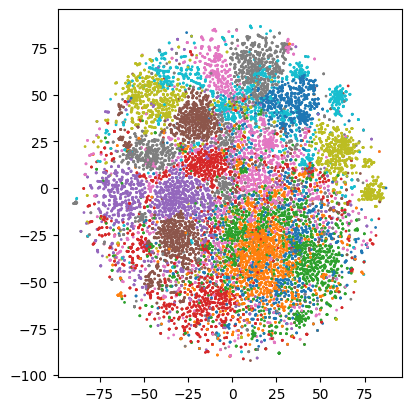

time: 631 ms (started: 2023-06-14 09:31:33 -07:00)


In [52]:
plt.figure(figsize=(4, 4), layout="constrained")
plt.scatter(*Z2.T, c=newsgroups.target, s=1, cmap="tab10")

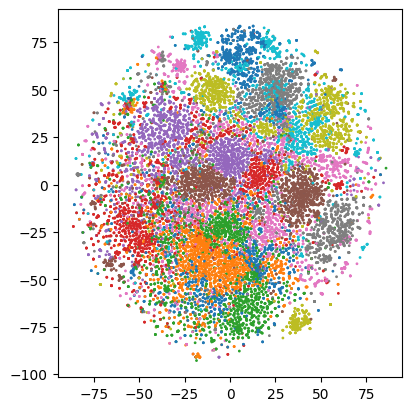

time: 557 ms (started: 2023-06-14 09:31:50 -07:00)


In [53]:
plt.figure(figsize=(4, 4), layout="constrained")
plt.scatter(*Z1.T, c=newsgroups.target, s=1, cmap="tab10")

In [17]:
# SVD to 500 components, L2 normalization, then t-SNE

plt.figure(figsize=(4,4), layout='constrained')

plt.scatter(*Zs[np.where(np.array(all_components) == 500)[0][0]][1].T, c=newsgroups.target, s=1, cmap='tab10')

<IPython.core.display.Javascript object>

In [18]:
import seaborn as sns

In [20]:
sns.scatterplot(*Zs[np.where(np.array(all_components) == 500)[0][0]][1].T, c=newsgroups.target, s=1, cmap='tab10')

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

In [9]:
from drnb.io import read_pickle

iclr_text = read_pickle(
    "iclr",
    suffix="text",
)

time: 819 ms (started: 2023-06-03 12:50:40 -07:00)


In [10]:
iclr_tfidf = TfidfVectorizer(norm="l2", sublinear_tf=True).fit_transform(iclr_text)

time: 1.89 s (started: 2023-06-03 12:50:43 -07:00)


In [11]:
iclr_svd = TruncatedSVD(
    n_components=np.max(all_components), random_state=42, algorithm="arpack"
).fit_transform(iclr_tfidf)

time: 1h 1min 38s (started: 2023-06-03 12:50:45 -07:00)


In [12]:
iclr_Zs = []

for nc in all_components:
    print(".", end="")

    iclr_Z1 = TSNE().fit(iclr_svd[:, :nc])
    iclr_Z2 = TSNE().fit(normalize(iclr_svd[:, :nc], axis=1))

    iclr_Zs.append((iclr_Z1, iclr_Z2))

.

[13:52:34] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=853641;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=700941;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=928050;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=838150;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[13:52:41] INFO     Automatically determined negative gradient method `fft`                              ]8;id=735334;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=710911;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[13:53:39] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=838265;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=541793;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=149180;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=525327;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[13:53:46] INFO     Automatically determined negative gradient method `fft`                              ]8;id=207371;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=803399;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

.

[13:54:45] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=878174;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=805691;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=191095;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=345441;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[13:54:52] INFO     Automatically determined negative gradient method `fft`                              ]8;id=996138;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=247180;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[13:55:46] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=401425;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=244409;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=832894;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=6576;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[13:55:53] INFO     Automatically determined negative gradient method `fft`                              ]8;id=117866;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=617858;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

.

[13:56:51] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=305009;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=475175;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=395644;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=355116;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[13:56:58] INFO     Automatically determined negative gradient method `fft`                              ]8;id=936207;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=387914;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[13:57:51] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=734480;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=629159;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=336292;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=705193;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[13:57:57] INFO     Automatically determined negative gradient method `fft`                              ]8;id=886609;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=281266;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

.

[13:58:57] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=953447;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=392159;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=127924;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=716229;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[13:59:05] INFO     Automatically determined negative gradient method `fft`                              ]8;id=661711;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=970139;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:00:01] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=66243;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=716230;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[14:00:02] INFO     Automatically determined negative gradient method `fft`                              ]8;id=933015;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=785559;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:00:09] INFO     Automatically determined negative gradient method `fft`                              ]8;id=387382;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=680979;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

.

[14:01:16] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=671611;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=161899;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=504121;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=588284;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:01:24] INFO     Automatically determined negative gradient method `fft`                              ]8;id=422768;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=619110;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:02:23] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=370633;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=970073;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=98140;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=149183;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:02:30] INFO     Automatically determined negative gradient method `fft`                              ]8;id=109289;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=933638;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

.

[14:03:41] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=809785;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=601625;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=749292;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=992585;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:03:49] INFO     Automatically determined negative gradient method `fft`                              ]8;id=107467;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=595427;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:04:50] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=600264;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=251285;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[14:04:51] INFO     Automatically determined negative gradient method `fft`                              ]8;id=913227;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=417285;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:04:58] INFO     Automatically determined negative gradient method `fft`                              ]8;id=81537;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=509733;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

.

[14:06:17] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=990224;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=353427;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=139445;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=321335;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:06:25] INFO     Automatically determined negative gradient method `fft`                              ]8;id=877438;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=680657;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:07:35] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=647918;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=212072;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=162419;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=254121;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:07:42] INFO     Automatically determined negative gradient method `fft`                              ]8;id=895829;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=443054;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

.

[14:09:37] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=166205;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=14686;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[14:09:38] INFO     Automatically determined negative gradient method `fft`                              ]8;id=432572;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=98483;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:09:45] INFO     Automatically determined negative gradient method `fft`                              ]8;id=851506;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=663409;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:11:25] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=592808;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=171877;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[14:11:26] INFO     Automatically determined negative gradient method `fft`                              ]8;id=381054;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=417626;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:11:33] INFO     Automatically determined negative gradient method `fft`                              ]8;id=933133;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=485104;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

.

[14:14:49] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=640774;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=969302;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[14:14:51] INFO     Automatically determined negative gradient method `fft`                              ]8;id=457767;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=118398;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:14:58] INFO     Automatically determined negative gradient method `fft`                              ]8;id=266814;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=404293;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:18:08] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=683369;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=403915;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[14:18:09] INFO     Automatically determined negative gradient method `fft`                              ]8;id=711772;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=784654;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:18:16] INFO     Automatically determined negative gradient method `fft`                              ]8;id=922897;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=520342;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

.

[14:23:21] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=840746;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=998477;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[14:23:24] INFO     Automatically determined negative gradient method `fft`                              ]8;id=472608;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=593548;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:23:32] INFO     Automatically determined negative gradient method `fft`                              ]8;id=152905;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=122388;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:28:28] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=793915;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=157040;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[14:28:31] INFO     Automatically determined negative gradient method `fft`                              ]8;id=485097;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=714452;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:28:38] INFO     Automatically determined negative gradient method `fft`                              ]8;id=723297;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=342535;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

.

[14:34:38] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=477718;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=795378;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[14:34:41] INFO     Automatically determined negative gradient method `fft`                              ]8;id=406051;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=41291;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:34:49] INFO     Automatically determined negative gradient method `fft`                              ]8;id=582280;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=889612;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:40:46] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=685213;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=788836;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[14:40:49] INFO     Automatically determined negative gradient method `fft`                              ]8;id=345924;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=338569;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:40:56] INFO     Automatically determined negative gradient method `fft`                              ]8;id=81398;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=373119;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

.

[14:48:21] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=687625;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=718902;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[14:48:25] INFO     Automatically determined negative gradient method `fft`                              ]8;id=44143;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=761556;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:48:33] INFO     Automatically determined negative gradient method `fft`                              ]8;id=833426;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=471754;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:55:46] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=274724;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=346317;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[14:55:50] INFO     Automatically determined negative gradient method `fft`                              ]8;id=607964;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=505566;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[14:55:58] INFO     Automatically determined negative gradient method `fft`                              ]8;id=338820;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=37039;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

time: 1h 4min 20s (started: 2023-06-03 13:52:24 -07:00)


In [16]:
from drnb.io.dataset import read_target

time: 917 µs (started: 2023-06-03 15:06:29 -07:00)


In [17]:
iclr_target = read_target("iclr")

time: 84.3 ms (started: 2023-06-03 15:06:43 -07:00)


In [18]:
iclr_target.shape

(16554, 3)

time: 3.71 ms (started: 2023-06-03 15:06:49 -07:00)


In [24]:
iclr_target["class"].values

array([ 0,  2, 31, ...,  1, 16,  0])

time: 4.7 ms (started: 2023-06-03 15:07:25 -07:00)


In [28]:
print(f'TF-IDF: {knn_accuracy(iclr_tfidf, y=iclr_target["class"].values):.2f}\n')

print("SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))")

for i, nc in enumerate(all_components):
    norms = np.sqrt(np.sum(svd[:, :nc] ** 2, axis=1, keepdims=True))

    print(
        f'    {nc:4}     {knn_accuracy(iclr_svd[:,:nc], y=iclr_target["class"].values):.2f}'
        f'        {knn_accuracy(normalize(iclr_svd[:,:nc], axis=1), y=iclr_target["class"].values):.2f}'
        f'          {knn_accuracy(iclr_Zs[i][0], y=iclr_target["class"].values):.2f}'
        f'              {knn_accuracy(iclr_Zs[i][1], y=iclr_target["class"].values):.2f}'
    )

TF-IDF: 0.63

SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))
      10     0.55        0.55          0.53              0.56
      50     0.63        0.62          0.60              0.60
     100     0.64        0.65          0.63              0.61
     200     0.64        0.64          0.62              0.61
     300     0.63        0.64          0.62              0.62
     400     0.62        0.64          0.62              0.62
     500     0.61        0.63          0.62              0.61
    1000     0.58        0.64          0.61              0.61
    2000     0.57        0.63          0.61              0.61
    3000     0.61        0.63          0.61              0.61
    3500     0.62        0.64          0.60              0.61
    4000     0.63        0.64          0.59              0.62
time: 56.3 s (started: 2023-06-03 15:17:41 -07:00)


In [29]:
print(
    f'TF-IDF: {knn_accuracy(iclr_tfidf, y=iclr_target["class"].values, balanced=True):.2f}\n'
)

print("SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))")

for i, nc in enumerate(all_components):
    norms = np.sqrt(np.sum(svd[:, :nc] ** 2, axis=1, keepdims=True))

    print(
        f'    {nc:4}     {knn_accuracy(iclr_svd[:,:nc], y=iclr_target["class"].values, balanced=True):.2f}'
        f'        {knn_accuracy(normalize(iclr_svd[:,:nc], axis=1), y=iclr_target["class"].values, balanced=True):.2f}'
        f'          {knn_accuracy(iclr_Zs[i][0], y=iclr_target["class"].values, balanced=True):.2f}'
        f'              {knn_accuracy(iclr_Zs[i][1], y=iclr_target["class"].values, balanced=True):.2f}'
    )

TF-IDF: 0.54

SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))
      10     0.22        0.23          0.23              0.26
      50     0.44        0.49          0.47              0.46
     100     0.49        0.56          0.53              0.51
     200     0.47        0.58          0.52              0.53
     300     0.45        0.60          0.52              0.55
     400     0.43        0.60          0.52              0.54
     500     0.38        0.58          0.50              0.52
    1000     0.28        0.57          0.48              0.50
    2000     0.29        0.56          0.46              0.48
    3000     0.38        0.55          0.46              0.48
    3500     0.45        0.54          0.45              0.48
    4000     0.50        0.54          0.45              0.48
time: 55.8 s (started: 2023-06-03 15:18:54 -07:00)


In [45]:
import seaborn as sns


def seascatter_ng20(n_components=500, normalized=False, alpha=1.0):
    # first extract your data
    indices = np.where(np.array(all_components) == n_components)[0][0]
    if normalized:
        zidx = 1
    else:
        zidx = 0
    x, y = Zs[indices][zidx].T

    data = pd.DataFrame({"X": x, "Y": y, "Color": newsgroups.target})

    sns.scatterplot(
        x="X",
        y="Y",
        hue="Color",
        palette="tab10",
        size=1,
        data=data,
        legend=False,
        alpha=alpha,
    )

time: 10.5 ms (started: 2023-06-03 16:06:08 -07:00)


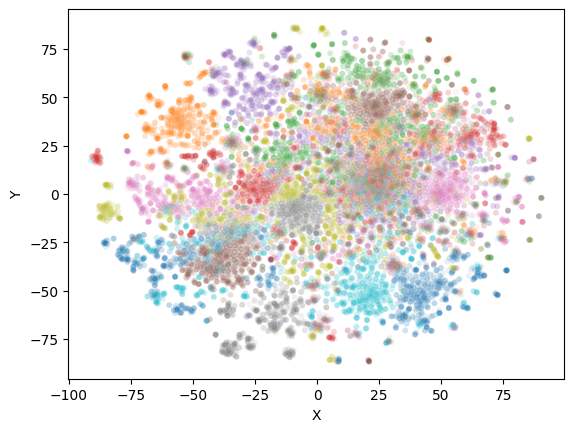

time: 665 ms (started: 2023-06-03 16:14:36 -07:00)


In [56]:
seascatter_ng20(400, False, alpha=0.1)

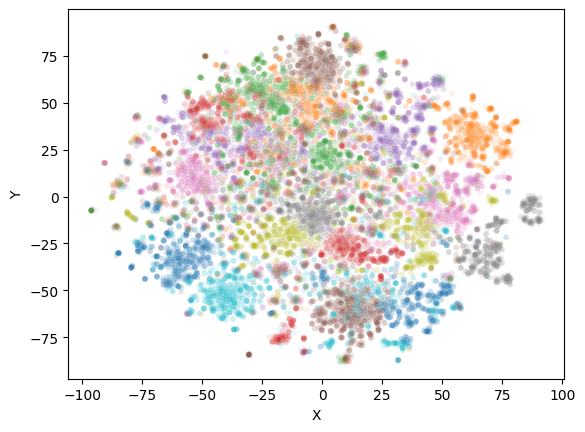

time: 698 ms (started: 2023-06-03 16:15:38 -07:00)


In [58]:
seascatter_ng20(400, True, alpha=0.1)

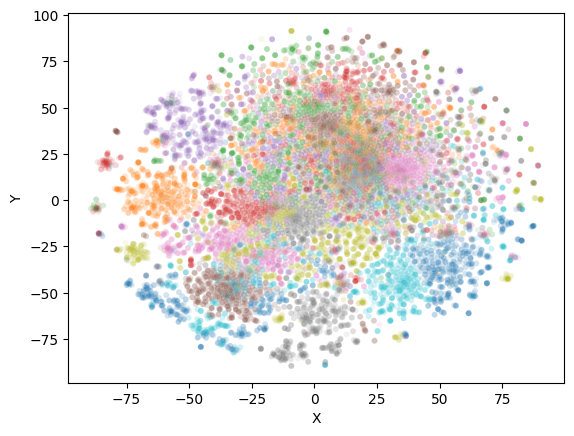

time: 718 ms (started: 2023-06-03 16:15:51 -07:00)


In [59]:
seascatter_ng20(1000, False, alpha=0.1)

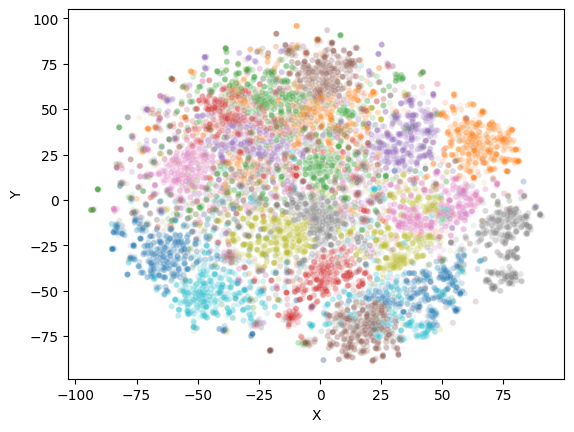

time: 693 ms (started: 2023-06-03 16:14:48 -07:00)


In [57]:
seascatter_ng20(1000, True, alpha=0.1)

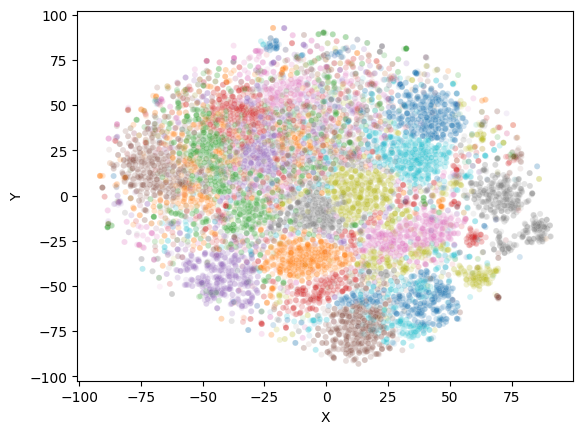

time: 711 ms (started: 2023-06-03 16:10:51 -07:00)


In [54]:
seascatter_ng20(4000, True, alpha=0.1)

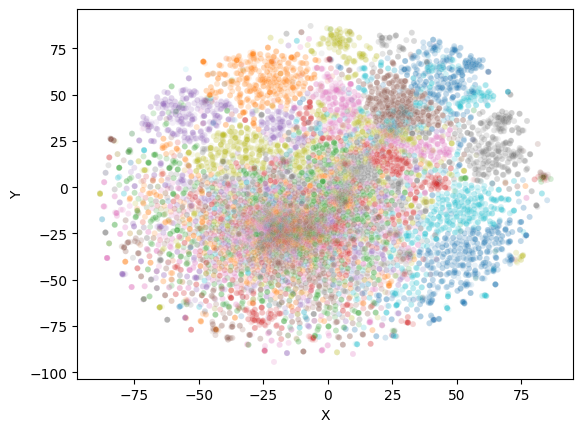

time: 695 ms (started: 2023-06-03 16:10:55 -07:00)


In [55]:
seascatter_ng20(4000, False, alpha=0.1)

In [50]:
def seascatter_iclr(n_components=500, normalized=False, alpha=1.0):
    # first extract your data
    indices = np.where(np.array(all_components) == n_components)[0][0]
    if normalized:
        zidx = 1
    else:
        zidx = 0
    x, y = iclr_Zs[indices][zidx].T

    data = pd.DataFrame({"X": x, "Y": y, "Color": iclr_target["class"].values})

    sns.scatterplot(
        x="X",
        y="Y",
        hue="Color",
        palette="tab10",
        size=1,
        data=data,
        legend=False,
        alpha=alpha,
    )

time: 10.3 ms (started: 2023-06-03 16:06:50 -07:00)


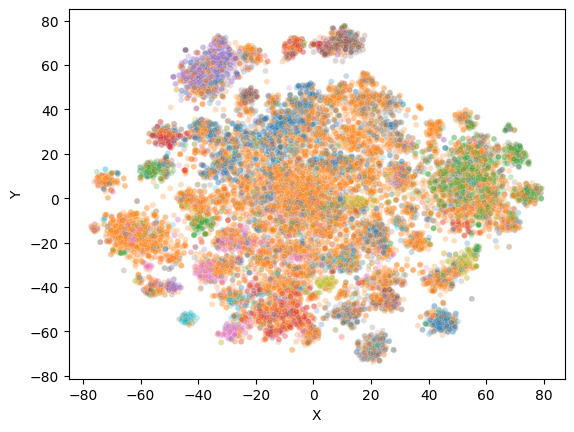

time: 659 ms (started: 2023-06-03 16:06:58 -07:00)


In [52]:
seascatter_iclr(100, False, alpha=0.25)

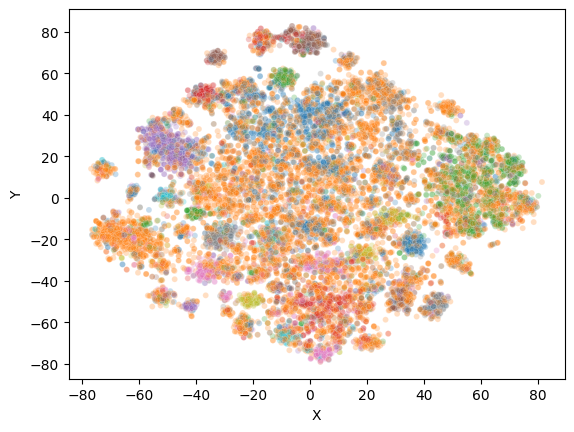

time: 620 ms (started: 2023-06-03 16:07:04 -07:00)


In [53]:
seascatter_iclr(300, True, alpha=0.25)

In [66]:
print(f'Full: {knn_accuracy(mnist, y=mnist_target["class"].values):.2f}\n')

print("SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))")

for i, nc in enumerate(all_components[:7]):
    norms = np.sqrt(np.sum(svd[:, :nc] ** 2, axis=1, keepdims=True))

    print(
        f'    {nc:4}     {knn_accuracy(mnist_svd[:,:nc], y=mnist_target["class"].values):.2f}'
        f'        {knn_accuracy(normalize(mnist_svd[:,:nc], axis=1), y=mnist_target["class"].values):.2f}'
        f'          {knn_accuracy(mnist_Zs[i][0], y=mnist_target["class"].values):.2f}'
        f'              {knn_accuracy(mnist_Zs[i][1], y=mnist_target["class"].values):.2f}'
    )

Full: 0.97

SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))
      10     0.93        0.93          0.91              0.92
      50     0.97        0.97          0.98              0.98
     100     0.97        0.97          0.97              0.97
     200     0.97        0.97          0.97              0.97
     300     0.97        0.97          0.97              0.97
     400     0.97        0.97          0.97              0.97
     500     0.97        0.97          0.97              0.97
time: 51.3 s (started: 2023-06-03 17:15:49 -07:00)


In [67]:
from drnb.io.dataset import read_dataset

mnist, mnist_target = read_dataset("kuzushiji")

time: 1.28 s (started: 2023-06-03 17:23:46 -07:00)


In [70]:
mnist_target = mnist_target.values

time: 866 µs (started: 2023-06-03 17:24:29 -07:00)


In [71]:
mnist_svd = TruncatedSVD(
    n_components=np.max(all_components[:7]), random_state=42, algorithm="arpack"
).fit_transform(mnist)

time: 29.9 s (started: 2023-06-03 17:24:46 -07:00)


In [72]:
mnist_Zs = []

for nc in all_components[:7]:
    mnist_Z1 = TSNE().fit(mnist_svd[:, :nc])
    mnist_Z2 = TSNE().fit(normalize(mnist_svd[:, :nc], axis=1))

    mnist_Zs.append((mnist_Z1, mnist_Z2))

[17:26:04] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=682246;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=680887;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=366210;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=807858;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:26:26] INFO     Automatically determined negative gradient method `fft`                              ]8;id=701437;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=180883;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:28:51] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=838903;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=849900;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=223718;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=45718;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:29:13] INFO     Automatically determined negative gradient method `fft`                              ]8;id=675666;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=176442;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:31:36] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=38988;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=979535;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=112541;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=984631;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:32:01] INFO     Automatically determined negative gradient method `fft`                              ]8;id=812707;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=50181;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:34:33] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=228069;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=40747;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=780352;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=951534;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:34:58] INFO     Automatically determined negative gradient method `fft`                              ]8;id=576748;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=724682;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:37:32] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=25506;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=334873;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=842965;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=637664;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:37:56] INFO     Automatically determined negative gradient method `fft`                              ]8;id=225562;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=876686;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:40:25] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=268637;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=199994;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[17:40:26] INFO     Automatically determined negative gradient method `fft`                              ]8;id=955655;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=709221;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:40:49] INFO     Automatically determined negative gradient method `fft`                              ]8;id=275517;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=189911;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:43:44] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=509506;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=256050;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=150558;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=266875;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:44:09] INFO     Automatically determined negative gradient method `fft`                              ]8;id=746151;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=279799;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:47:00] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=84374;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=194774;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[17:47:01] INFO     Automatically determined negative gradient method `fft`                              ]8;id=523117;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=986602;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:47:25] INFO     Automatically determined negative gradient method `fft`                              ]8;id=827733;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=493929;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:50:42] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=898077;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=729989;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[17:50:43] INFO     Automatically determined negative gradient method `fft`                              ]8;id=816680;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=17888;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:51:10] INFO     Automatically determined negative gradient method `fft`                              ]8;id=724729;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=745707;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:54:29] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=500114;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=160236;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[17:54:30] INFO     Automatically determined negative gradient method `fft`                              ]8;id=535819;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=999013;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:54:54] INFO     Automatically determined negative gradient method `fft`                              ]8;id=633607;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=318657;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:58:33] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=397207;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=881558;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[17:58:34] INFO     Automatically determined negative gradient method `fft`                              ]8;id=379348;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=891093;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[17:58:59] INFO     Automatically determined negative gradient method `fft`                              ]8;id=240969;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=121317;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:02:42] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=422363;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=550906;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=916759;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=898457;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:03:07] INFO     Automatically determined negative gradient method `fft`                              ]8;id=694347;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=242684;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:07:18] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=357480;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=244434;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[18:07:19] INFO     Automatically determined negative gradient method `fft`                              ]8;id=262146;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=573660;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:07:45] INFO     Automatically determined negative gradient method `fft`                              ]8;id=595768;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=28624;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:11:58] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=762299;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=199449;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[18:11:59] INFO     Automatically determined negative gradient method `fft`                              ]8;id=52111;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=985599;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:12:23] INFO     Automatically determined negative gradient method `fft`                              ]8;id=776602;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=315251;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

time: 48min 46s (started: 2023-06-03 17:25:16 -07:00)


In [74]:
print(f"Full: {knn_accuracy(mnist, y=mnist_target):.2f}\n")

print("SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))")

for i, nc in enumerate(all_components[:7]):
    print(
        f"    {nc:4}     {knn_accuracy(mnist_svd[:,:nc], y=mnist_target):.2f}"
        f"        {knn_accuracy(normalize(mnist_svd[:,:nc], axis=1), y=mnist_target):.2f}"
        f"          {knn_accuracy(mnist_Zs[i][0], y=mnist_target):.2f}"
        f"              {knn_accuracy(mnist_Zs[i][1], y=mnist_target):.2f}"
    )

Full: 0.96

SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))
      10     0.88        0.88          0.86              0.86
      50     0.97        0.98          0.97              0.98
     100     0.97        0.98          0.97              0.98
     200     0.97        0.98          0.97              0.98
     300     0.96        0.98          0.97              0.98
     400     0.96        0.97          0.97              0.97
     500     0.96        0.97          0.97              0.98
time: 52.1 s (started: 2023-06-03 18:16:14 -07:00)


In [84]:
def seascatter_mnist(n_components=500, normalized=False, alpha=1.0):
    # first extract your data
    indices = np.where(np.array(all_components) == n_components)[0][0]
    if normalized:
        zidx = 1
    else:
        zidx = 0
    x, y = mnist_Zs[indices][zidx].T

    data = pd.DataFrame({"X": x, "Y": y, "Color": mnist_target})

    sns.scatterplot(
        x="X",
        y="Y",
        hue="Color",
        palette="tab10",
        size=1,
        data=data,
        legend=False,
        alpha=alpha,
    )

time: 6.64 ms (started: 2023-06-03 18:19:44 -07:00)


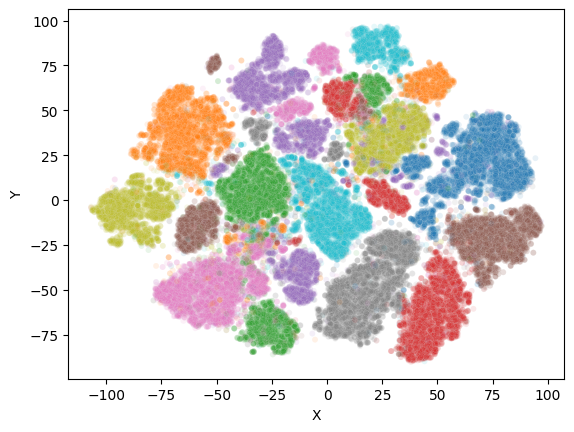

time: 2.01 s (started: 2023-06-03 18:20:15 -07:00)


In [87]:
seascatter_mnist(n_components=300, normalized=False, alpha=0.1)

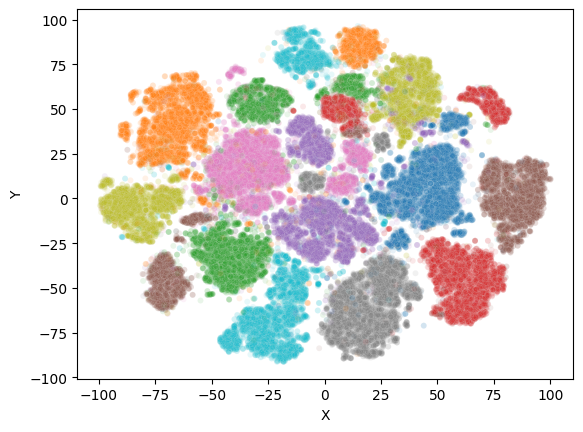

time: 1.97 s (started: 2023-06-03 18:20:21 -07:00)


In [88]:
seascatter_mnist(n_components=300, normalized=True, alpha=0.1)

In [89]:
mnist_svd = TruncatedSVD(
    n_components=np.max(all_components[:7]), random_state=42, algorithm="arpack"
).fit_transform(normalize(mnist))

time: 25.8 s (started: 2023-06-03 18:30:55 -07:00)


In [90]:
mnist_Zs = []

for nc in all_components[:7]:
    mnist_Z1 = TSNE().fit(mnist_svd[:, :nc])
    mnist_Z2 = TSNE().fit(normalize(mnist_svd[:, :nc], axis=1))

    mnist_Zs.append((mnist_Z1, mnist_Z2))

[18:32:06] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=351473;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=350782;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=957841;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=122837;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:32:29] INFO     Automatically determined negative gradient method `fft`                              ]8;id=854994;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=243898;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:34:50] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=383806;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=667985;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=24580;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=992185;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:35:13] INFO     Automatically determined negative gradient method `fft`                              ]8;id=306029;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=755533;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:37:35] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=785406;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=27707;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=505408;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=287313;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:37:58] INFO     Automatically determined negative gradient method `fft`                              ]8;id=819019;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=196995;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:40:23] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=730716;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=383927;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[18:40:24] INFO     Automatically determined negative gradient method `fft`                              ]8;id=746652;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=411161;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:40:47] INFO     Automatically determined negative gradient method `fft`                              ]8;id=57929;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=199021;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:43:20] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=171814;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=361429;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=845644;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=282742;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:43:43] INFO     Automatically determined negative gradient method `fft`                              ]8;id=784509;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=71843;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:46:16] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=565585;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=823968;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=733104;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=158094;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:46:39] INFO     Automatically determined negative gradient method `fft`                              ]8;id=430680;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=35183;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:49:32] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=386974;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=955437;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[18:49:33] INFO     Automatically determined negative gradient method `fft`                              ]8;id=653715;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=7905;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:49:58] INFO     Automatically determined negative gradient method `fft`                              ]8;id=281958;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=4067;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:52:54] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=127397;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=802529;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[18:52:55] INFO     Automatically determined negative gradient method `fft`                              ]8;id=723073;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=266446;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:53:20] INFO     Automatically determined negative gradient method `fft`                              ]8;id=34181;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=423636;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:56:42] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=257132;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=874648;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[18:56:43] INFO     Automatically determined negative gradient method `fft`                              ]8;id=725791;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=341689;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[18:57:08] INFO     Automatically determined negative gradient method `fft`                              ]8;id=891416;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=770494;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[19:00:35] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=17553;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=164265;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[19:00:40] INFO     Automatically determined negative gradient method `fft`                              ]8;id=388232;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=182325;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[19:01:06] INFO     Automatically determined negative gradient method `fft`                              ]8;id=385173;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=665959;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[19:04:58] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=891372;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=736260;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[19:04:59] INFO     Automatically determined negative gradient method `fft`                              ]8;id=685327;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=952183;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[19:05:24] INFO     Automatically determined negative gradient method `fft`                              ]8;id=42850;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=590299;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[19:09:08] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=157028;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=775553;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[19:09:09] INFO     Automatically determined negative gradient method `fft`                              ]8;id=45645;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=740720;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[19:09:34] INFO     Automatically determined negative gradient method `fft`                              ]8;id=792011;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=74148;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[19:13:47] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=305921;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=18132;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[19:13:48] INFO     Automatically determined negative gradient method `fft`                              ]8;id=67019;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=408009;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[19:14:13] INFO     Automatically determined negative gradient method `fft`                              ]8;id=367439;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=614535;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[19:18:27] INFO     Precomputed initialization provided. Ignoring initalization-related parameters.    ]8;id=667788;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=631498;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1347\1347]8;;\

[19:18:28] INFO     Automatically determined negative gradient method `fft`                              ]8;id=101621;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=433144;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

[19:18:53] INFO     Automatically determined negative gradient method `fft`                              ]8;id=25234;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=840341;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#52\52]8;;\

time: 49min 21s (started: 2023-06-03 18:31:21 -07:00)


In [91]:
print(f"Full: {knn_accuracy(mnist, y=mnist_target):.2f}\n")

print("SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))")

for i, nc in enumerate(all_components[:7]):
    print(
        f"    {nc:4}     {knn_accuracy(mnist_svd[:,:nc], y=mnist_target):.2f}"
        f"        {knn_accuracy(normalize(mnist_svd[:,:nc], axis=1), y=mnist_target):.2f}"
        f"          {knn_accuracy(mnist_Zs[i][0], y=mnist_target):.2f}"
        f"              {knn_accuracy(mnist_Zs[i][1], y=mnist_target):.2f}"
    )

Full: 0.96

SVD dim      SVD     L2(SVD)    t-SNE(SVD)    t-SNE(L2(SVD))
      10     0.89        0.87          0.87              0.86
      50     0.98        0.98          0.98              0.98
     100     0.98        0.98          0.98              0.98
     200     0.98        0.97          0.98              0.98
     300     0.98        0.98          0.98              0.98
     400     0.97        0.97          0.98              0.98
     500     0.98        0.97          0.98              0.98
time: 57.7 s (started: 2023-06-03 19:20:42 -07:00)


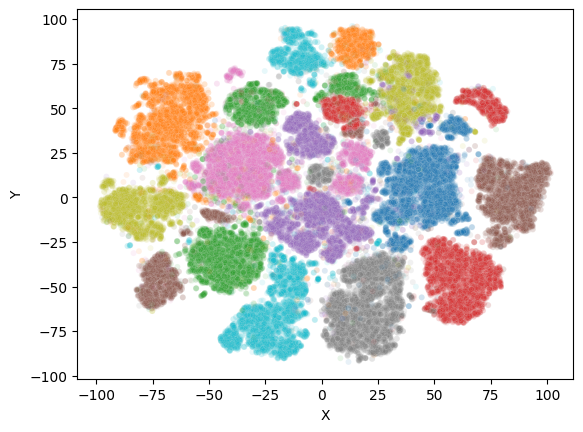

time: 2.05 s (started: 2023-06-03 19:24:17 -07:00)


In [92]:
seascatter_mnist(n_components=300, normalized=True, alpha=0.1)